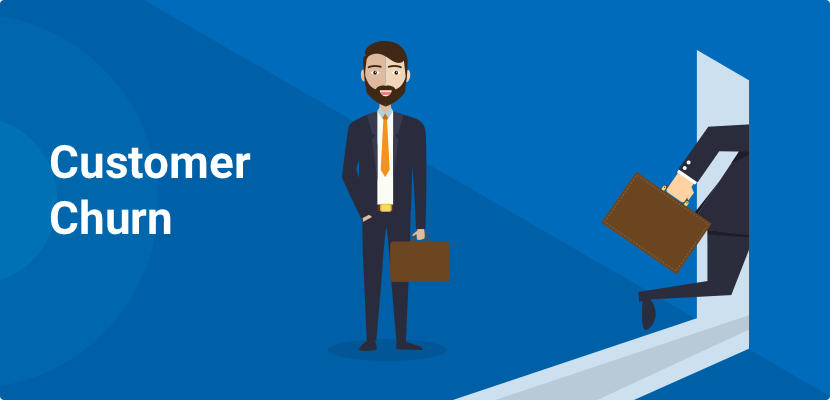

In [129]:
path = "/Users/hrd/Documents/Working/Sertification/Purwadhika/Practice Session/Project_Module_3/"
Image(filename = path + "churn2.png", width=1000, height=1000)

# Business Problem Understanding

**Context**

Divisi Big Data pada suatu perusahaan e-commerce sedang mengidentifikasi persentase pelanggan yang hilang atau pelanggan yang tidak berlangganan kembali di platform mereka. Pelanggan yang hilang dapat disebut customer churn. Perusahaan ingin agar pelanggan loyal dan tidak berhenti berlangganan pada platform mereka. Karena hal ini perusahaan sedang mengidentifikasi/memprediksi pelanggan yang tidak akan berlangganan kembali, kemudian memberikan penawaran khusus/istimewa agar pelanggan tetap loyal kepada produk/perusahaan.

**Problem Statement:**

Banyak faktor yang mempengaruhi alasan seorang pelanggan melakukan Churn. Mungkin fakta bahwa ada pesaing baru di pasar yang menawarkan harga lebih baik atau mungkin layanan yang mereka dapatkan belum sesuai standar, dll.

Oleh karena itu, tidak ada jawaban yang benar mengapa pelanggan ingin churn. Karena seperti yang dapat dilihat, terdapat banyak faktor yang mempengaruhi hal ini. Tugas seorang data scientist adalah menemukan pola seperti itu di dalam data historis.

**Goals:**

Berdasarkan permasalahan tersebut, perusahaan ingin memprediksi pelanggan mana yang loyal dan akan churn berdasankan waktu tertentu. Hal ini sejalan untuk meningkatkan potensi keuntungan yang akan diperoleh perusahaan. Karena hal tersebut, pada sesi ini kita akan memprediksi pelanggan yang akan churn dan tidak menggunakan pendekatan machine learning berdasarkan pola dalam di data yang tersedia. 

**Analytic Approach:**

Setelah perusahaan dapat memprediksi antara pelanggan yang akan churn dan yang tidak, kita dapat memberikan penawaran khusus dan hal-hal lain untuk membuat pelanggan tetap tinggal. 

**Metric Evaluation**

Type 1 error: False Positive

Konsekuensi: Sia-sia biaya penawaran khusus untuk pelanggan

Type 2 error: False Negative

Konsekuensi: Kehilangan pelanggan

Berdasarkan konsekuensinya, maka hal terbaik yang dapat dioptimasikan yaitu meminimalkan biara yang dikeluarkan untuk penawaran khusus untuk pelanggam tetapi juga tidak membuat pelanggan menjadi churn/tidak berlangganan lagi. Maka metric yang cocok untuk hal ini yaitu memaksimalkan nilai **Recall/True Positive Rate** dan meminimalkan **False Positive Rate**. Hal ini sama dengan mengoptimalkan nilai roc_auc, jadi yang akan kita gunakan adalah ROC AUC. Kemudian untuk opsi pembanding adalah recall yang setinggi-tingginya dan FPR yang seminim mungkin.

In [196]:
# Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import Image

# Feature engineering
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

# Model
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

# Evaluation
import shap 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

# Addition
import pickle
import sys
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Data Understanding

The dataset will be used is *data_ecommerce_customer_churn.csv*. After explore on internet, there's any data similar with this dataset with more column/feature. The owner of the data is *Ankit Verma* and the address source on the internet is in the following link.

Dataset yang akan digunakan adalah *data_ecommerce_customer_churn.csv*. Setelah diexplore di internet, ternyata terdapat data yang mirip dengan dataset ini dengan lebih banyak kolom/fitur. Pemilik data tersebut adalah *Ankit Verma* dengan link sebagai berikut.

* *https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction*.


There's another information about description of the dataset involved descripted in following table.

In [130]:
pd.options.display.max_colwidth = 90
table_description = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[2,3])
table_description.drop(index = [0, 3, 4, 6, 7, 8, 15, 16, 17]).reset_index(drop=True)

,Variable,Discerption
0,Churn,Churn Flag
1,Tenure,Tenure of customer in organization
2,WarehouseToHome,Distance in between warehouse to home of customer
3,NumberOfDeviceRegistered,Total number of deceives is registered on particular customer
4,PreferedOrderCat,Preferred order category of customer in last month
5,SatisfactionScore,Satisfactory score of customer on service
6,MaritalStatus,Marital status of customer
7,NumberOfAddress,Total number of added added on particular customer
8,Complain,Any complaint has been raised in last month
9,DaySinceLastOrder,Day Since last order by customer


# Exploratory Data Analysis (EDA)

Note:
- Setiap baris mewakili data historis seorang pelanggan

In [131]:
df_original = pd.read_csv('data_ecommerce_customer_churn.csv')

df = df_original.copy()
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


Insight:
* Tidak terdapat kesalahan/anomali pada tipe data
* Terdapat beberapa fitur yang memiliki missing value (Tenure, WarehouseToHome, DaySinceLastOrder)

In [133]:
df.describe(include='object').T

,count,unique,top,freq
PreferedOrderCat,3941,6,Laptop & Accessory,1458
MaritalStatus,3941,3,Married,2055


Kategori yang paling banyak disukai oleh pelanggan adalah kategori **Laptop & Accessory**. Kemudian dapat terlihat bahwa pelanggan yang paling banyak yaitu pelanggan yang sudah menikah.

In [134]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
Tenure,3747.0,10.081398,8.498864,0.0,2.0,9.00,16.00,61.00
WarehouseToHome,3772.0,15.650583,8.452301,5.0,9.0,14.00,21.00,127.00
NumberOfDeviceRegistered,3941.0,3.679269,1.013938,1.0,3.0,4.00,4.00,6.00
SatisfactionScore,3941.0,3.088302,1.381832,1.0,2.0,3.00,4.00,5.00
NumberOfAddress,3941.0,4.237757,2.626699,1.0,2.0,3.00,6.00,22.00
Complain,3941.0,0.282416,0.450232,0.0,0.0,0.00,1.00,1.00
DaySinceLastOrder,3728.0,4.531652,3.667648,0.0,2.0,3.00,7.00,46.00
CashbackAmount,3941.0,176.707419,48.791784,0.0,145.7,163.34,195.25,324.99
Churn,3941.0,0.171023,0.376576,0.0,0.0,0.00,0.00,1.00


In [135]:
# Unique value
data_type = [df[i].dtype for i in df.columns]
unique = [df[i].nunique() for i in df.columns]
unique_sample = [df[i].drop_duplicates().sample(2).values for i in df.columns]

df_unique = pd.DataFrame(data = {'Features': df.columns,
                                 'Data Type': data_type,
                                 'Number of Unique': unique,
                                 'Unique Samples': unique_sample})
df_unique

,Features,Data Type,Number of Unique,Unique Samples
0,Tenure,float64,36,"[14.0, 16.0]"
1,WarehouseToHome,float64,33,"[35.0, 28.0]"
2,NumberOfDeviceRegistered,int64,6,"[2, 6]"
3,PreferedOrderCat,object,6,"[Laptop & Accessory, Mobile Phone]"
4,SatisfactionScore,int64,5,"[3, 4]"
5,MaritalStatus,object,3,"[Single, Divorced]"
6,NumberOfAddress,int64,14,"[3, 2]"
7,Complain,int64,2,"[0, 1]"
8,DaySinceLastOrder,float64,22,"[7.0, 8.0]"
9,CashbackAmount,float64,2335,"[172.07, 25.0]"


In [136]:
# Duplicate data
display(df[df.duplicated(subset=None)])

df[(df['Tenure'] == 1) &
   (df['WarehouseToHome'] == 11) &
   (df['NumberOfDeviceRegistered'] == 4) &
   (df['PreferedOrderCat'] == 'Mobile Phone') & 
   (df['SatisfactionScore'] == 5) &
   (df['MaritalStatus'] == 'Single') &
   (df['NumberOfAddress'] == 3) &
   (df['Complain'] == 0) &
   (df['DaySinceLastOrder'] == 1) &
   (df['CashbackAmount'] == 154.73) &
   (df['Churn'] == 1)
  ]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
70,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1
128,1.0,10.0,4,Mobile Phone,1,Single,3,1,1.0,140.69,1
194,18.0,26.0,3,Laptop & Accessory,3,Single,9,0,1.0,148.50,0
253,19.0,6.0,3,Fashion,5,Married,2,0,7.0,204.53,0
289,16.0,36.0,4,Laptop & Accessory,3,Married,4,0,3.0,170.56,0
...,...,...,...,...,...,...,...,...,...,...,...
3930,22.0,17.0,3,Laptop & Accessory,1,Single,4,0,4.0,145.07,0
3932,20.0,15.0,5,Laptop & Accessory,5,Married,10,1,8.0,171.15,0
3934,10.0,25.0,3,Laptop & Accessory,3,Married,4,0,2.0,157.68,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
7,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1
70,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1


Dapat terlihat bahwa terdapat duplikat data pada dataset yang berjumlah 671 data. Kemudian untuk selanjutnya data duplikat akan didrop.

In [137]:
display(df)
display(df.drop_duplicates(subset=None, keep='first').reset_index(drop=True))

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3265,25.0,15.0,5,Fashion,4,Married,7,0,8.0,249.90,0
3266,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3267,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3268,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0


Setelah data duplikat didrop, data yang tersisa hanya sekitar 3270.

,Columns,% Missing Value
8,DaySinceLastOrder,0.054047
0,Tenure,0.049226
1,WarehouseToHome,0.042883
2,NumberOfDeviceRegistered,0.000000
3,PreferedOrderCat,0.000000
4,SatisfactionScore,0.000000
5,MaritalStatus,0.000000
6,NumberOfAddress,0.000000
7,Complain,0.000000
9,CashbackAmount,0.000000


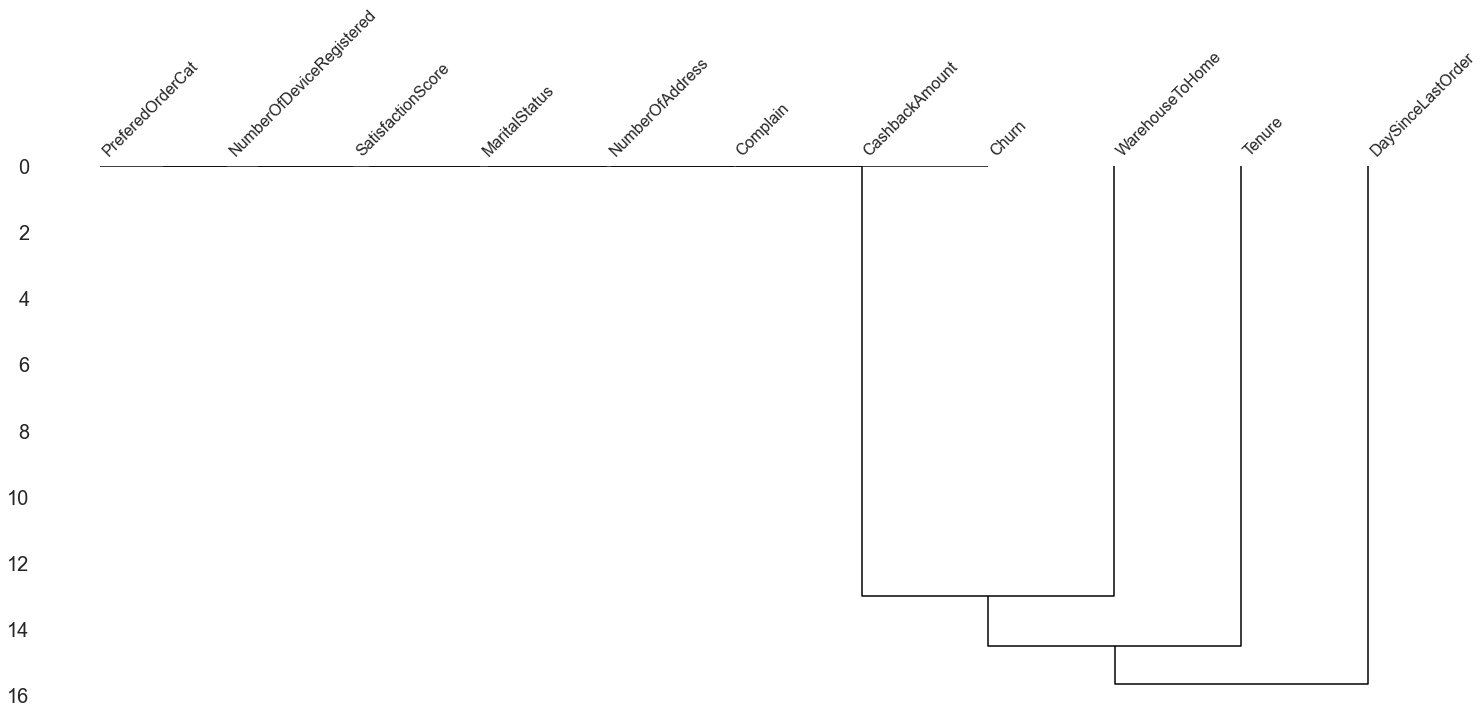

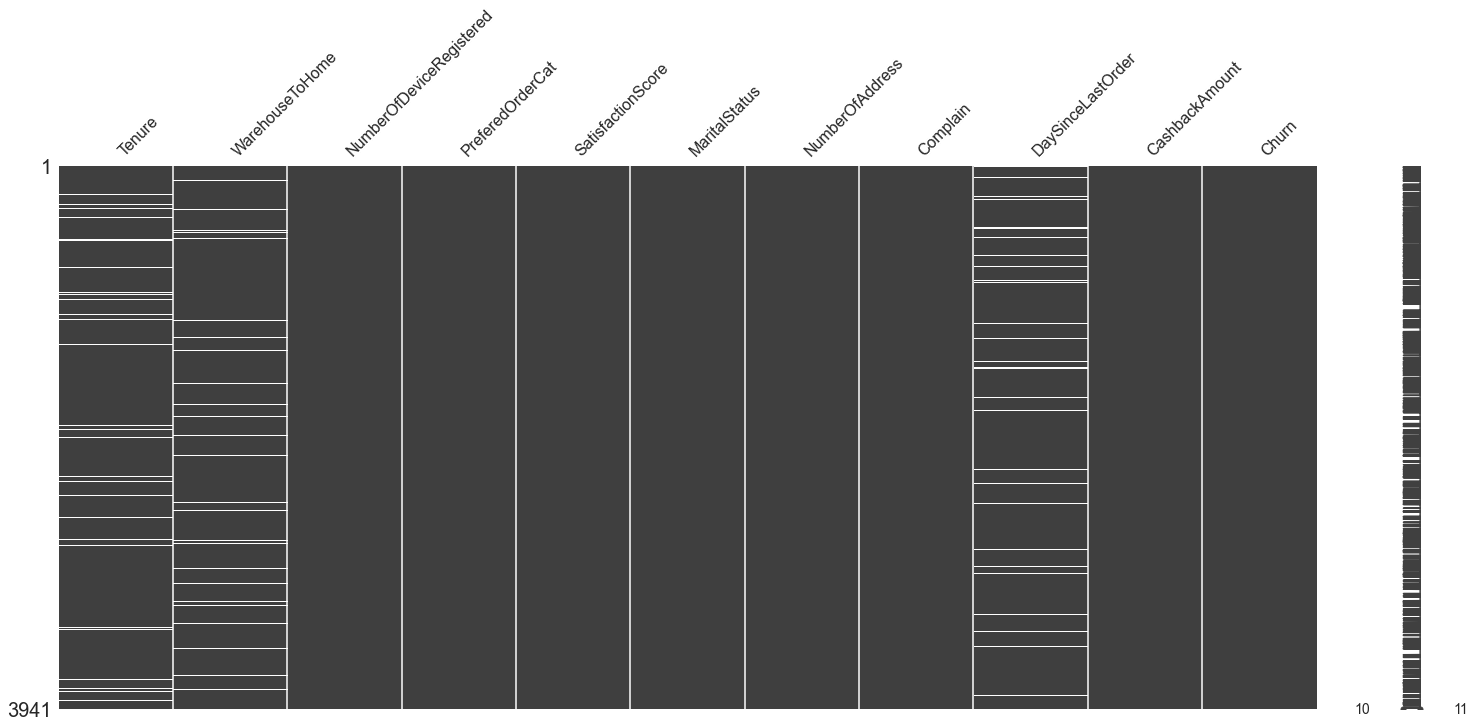

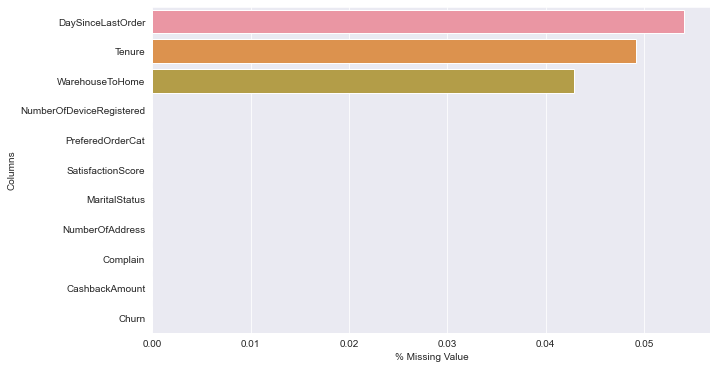

In [138]:
miss = pd.DataFrame(df.isnull().sum()/df.shape[0])\
                                .reset_index()\
                                .rename(columns={0:'% Missing Value',
                                                 'index':'Columns'})\
                                .sort_values('% Missing Value', ascending=False)

display(miss)

msno.dendrogram(df)
plt.show()

msno.matrix(df)
plt.show()

sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
sns.barplot(data=miss, y='Columns', x='% Missing Value')
plt.show()

- Dari data tersebut, dapat kita lihat bahwa persentase tertinggi data yang hilang adalah fitur **DaySinceLastOrder** yaitu sekitar 5.4%. Dari plot di atas juga dapat kita asumsikan bahwa data yang hilang merupakan kejadian random.
- Missing value pada data hanya terdapat pada data yang memiliki kategori numerik, untuk missing value handling akan dibandingkan menggunakan SimpleImputer, KnnImputer, dan MICE. Data yang paling mendekati dari central tendency yang akan digunakan (Mean dan standar deviasi).

0    0.828977
1    0.171023
Name: Churn, dtype: float64

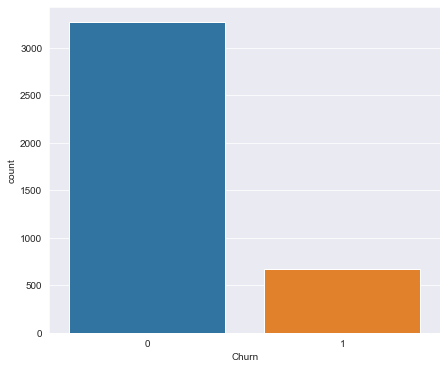

In [139]:
display(df['Churn'].value_counts()/df.shape[0])

plt.figure(figsize=(7,6))
sns.countplot(data=df, x='Churn')
plt.show()

Dari hasil plot, dapat diketahui bahwa data label terindikasi imbalanced dengan persentase 83%:17%

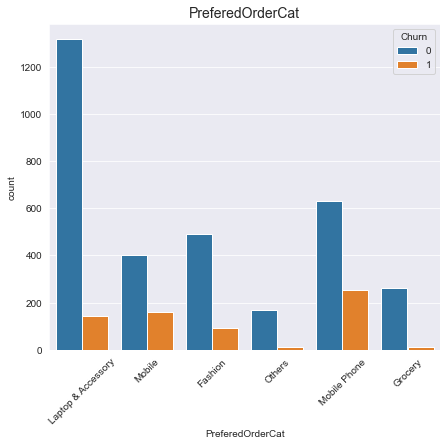

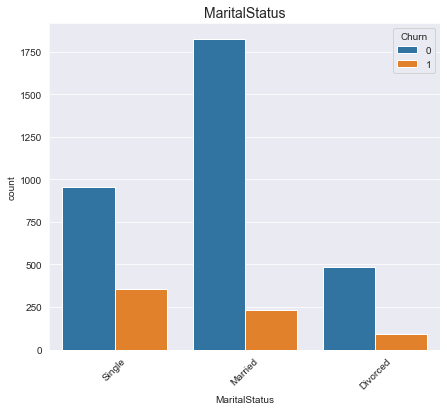

In [140]:
for col in df.describe(include='object').columns:
    plt.figure(figsize=(7,6))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(col, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

- Pelanggan yang paling banyak churn adalah pelanggan yang prefer pada kategori **mobile phone** dan pelanggan yang masih single.
- Data kategorikal ini bukan merupakan kategori ordinalitas/bertingkat. Jadi untuk encoding dapat dilakukan dengan cara binary encoding dan one hot encoding.

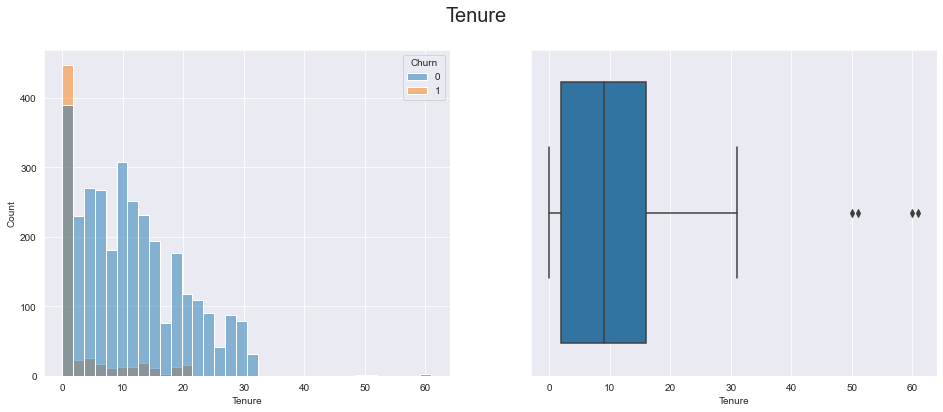

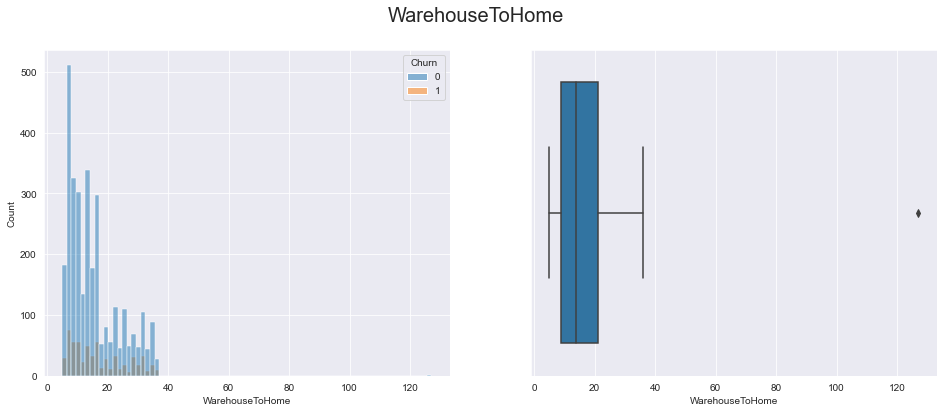

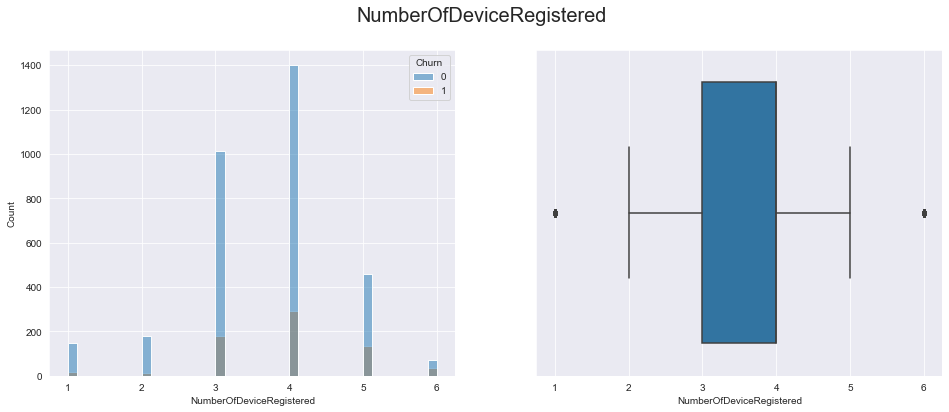

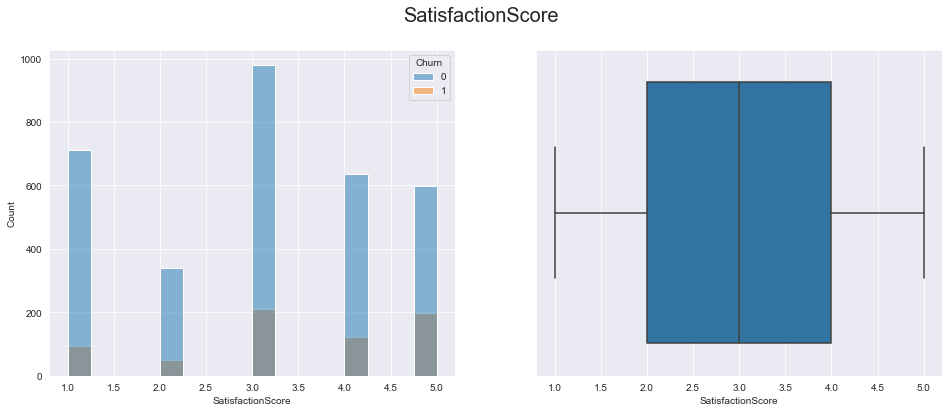

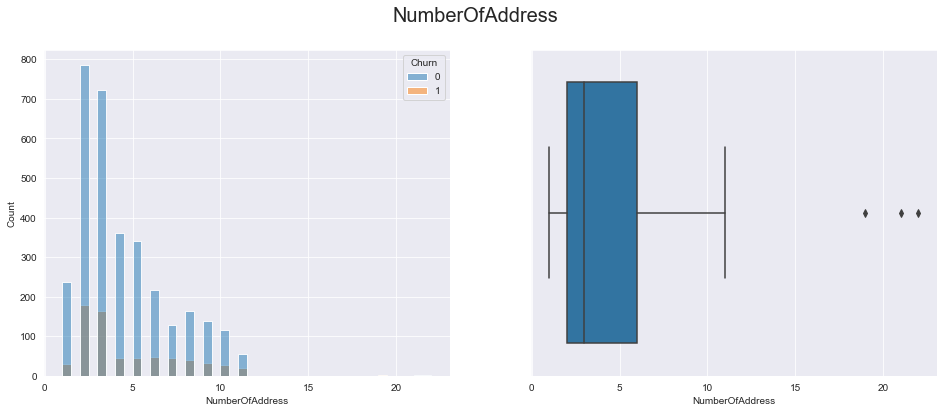

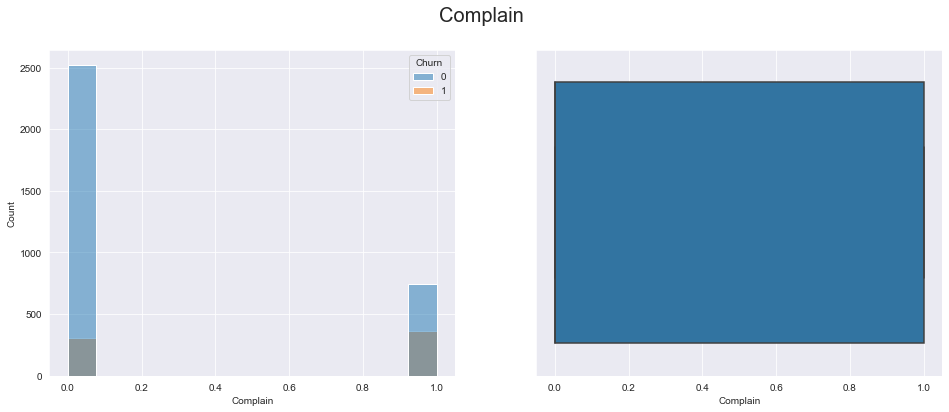

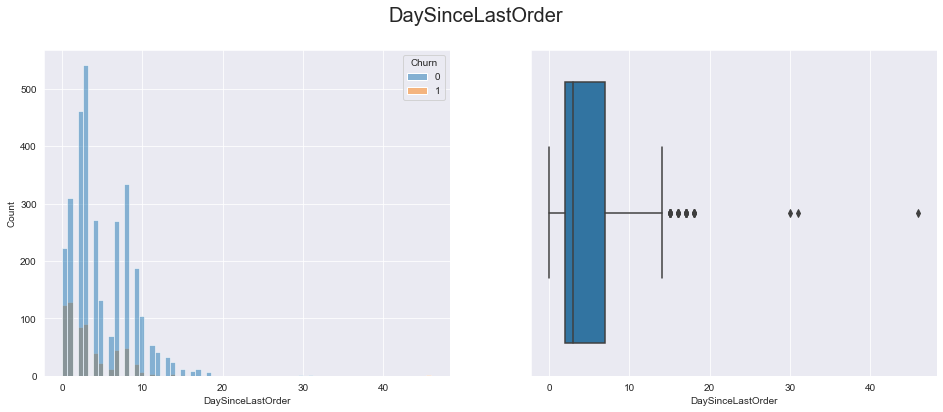

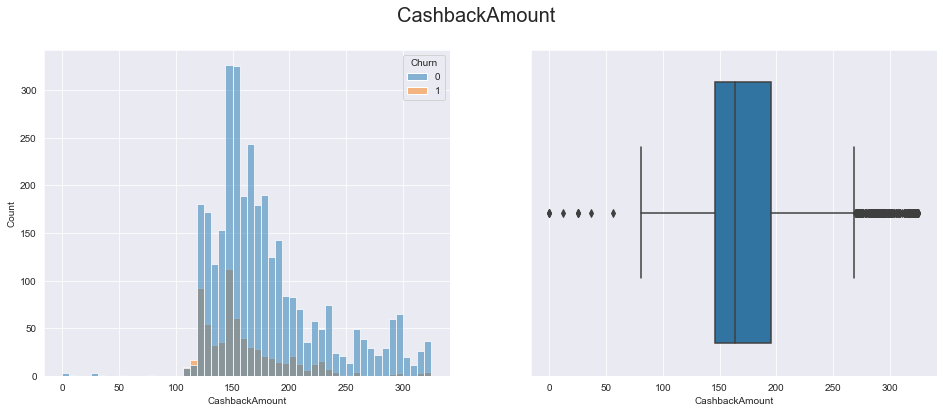

In [141]:
# with duplicate
for col in df.describe(exclude='object').columns[:-1]:
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    plt.suptitle(col, fontsize=20)
    sns.histplot(data=df, x=col, hue='Churn', ax=axes[0])
    sns.boxplot(data=df, x=col, hue='Churn', ax=axes[1])
    plt.show()

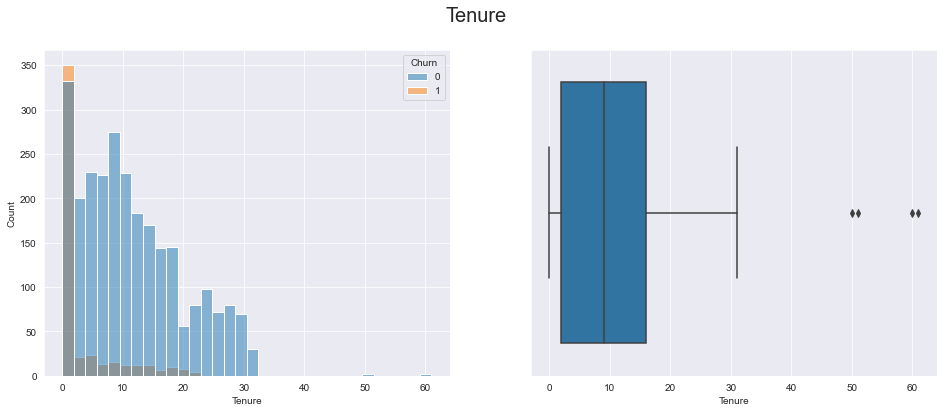

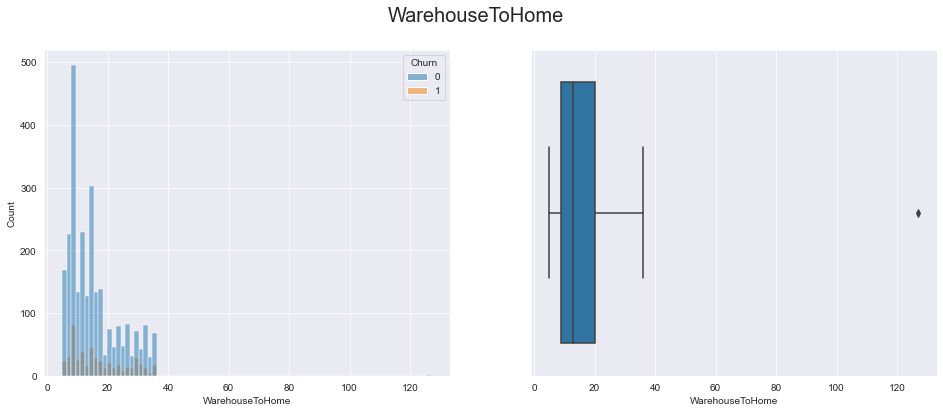

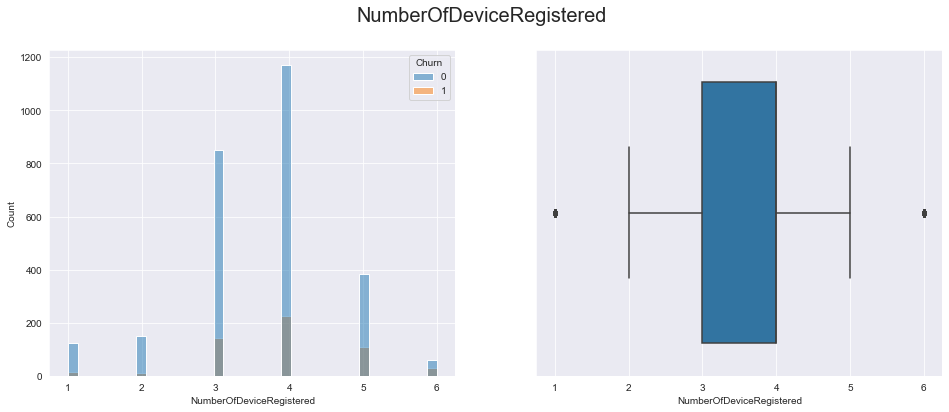

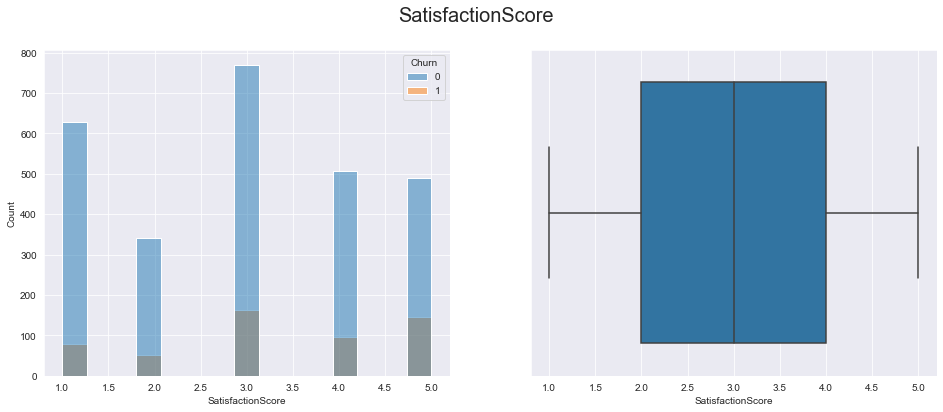

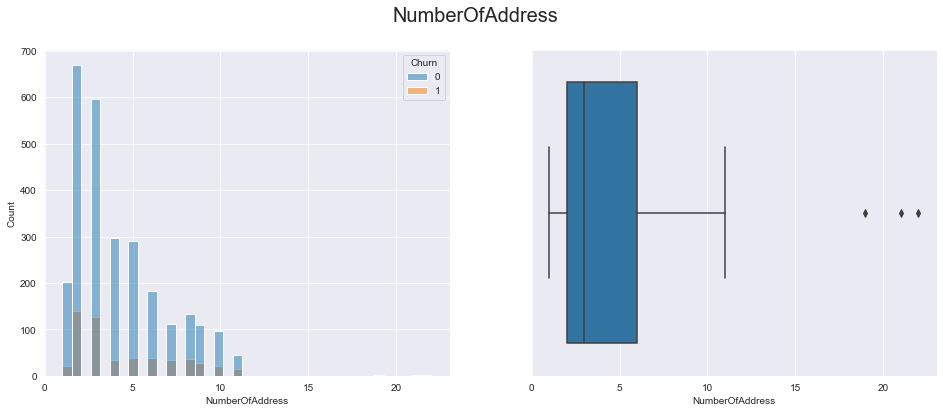

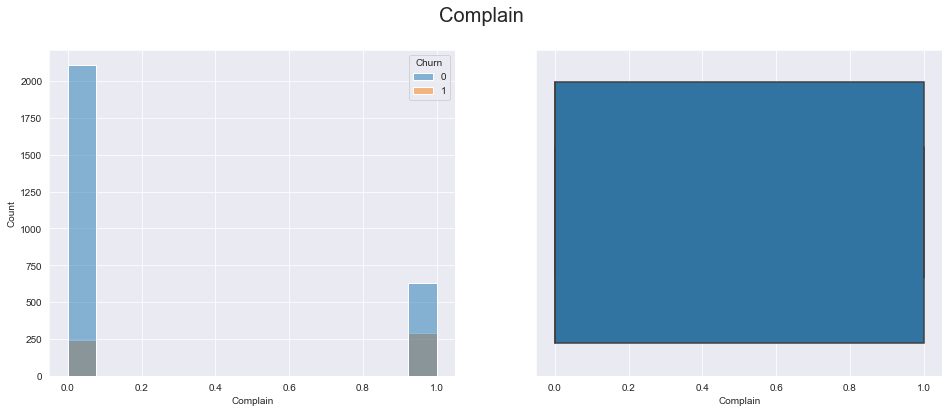

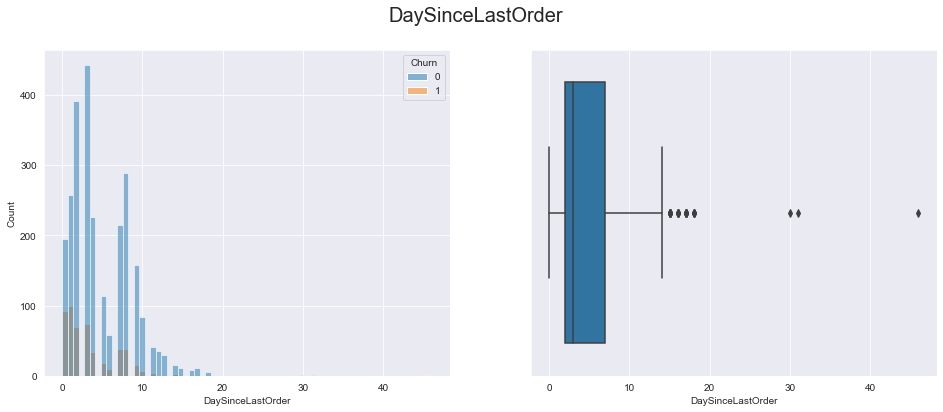

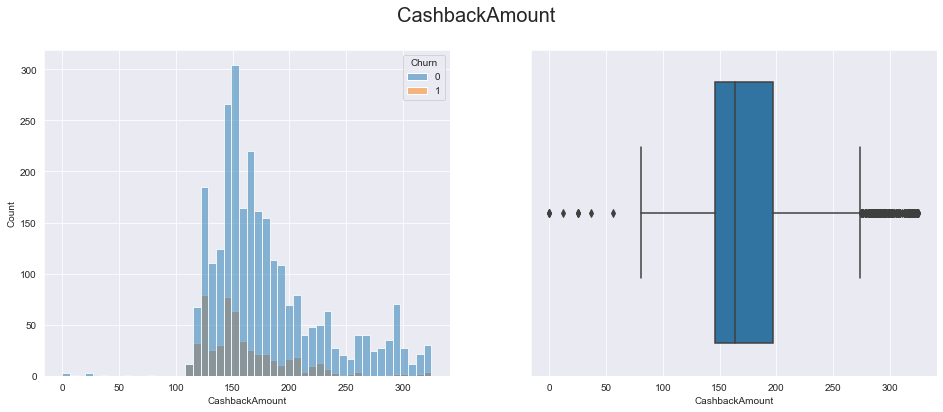

In [142]:
# No duplicate
for col in df.describe(exclude='object').columns[:-1]:
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    plt.suptitle(col, fontsize=20)
    sns.histplot(data=df.drop_duplicates(subset=None, keep='first'),
                 x=col, 
                 hue='Churn', 
                 ax=axes[0])
    sns.boxplot(data=df.drop_duplicates(subset=None, keep='first'), 
                x=col, 
                hue='Churn', 
                ax=axes[1])
    plt.show()

1. Terjadi sedikit perubahan pada distribusi data setelah data duplikat dihapus.
2. Fitur-fitur yang memiliki distribusi right skewed adalah sebagai berikut.
    - Tenure
    - WarehouseToHome
    - NumberOfAddress
    - DaySinceLastOrder
    - CashbackAmount
3. Outlier terdapat pada kolom adalah sebagai berikut.
    - Tenure
    - WarehouseToHome
    - NumberOfDeviceRegistered
    - NumberOfAddress
    - DaySinceLastOrder
    - CashbackAmount

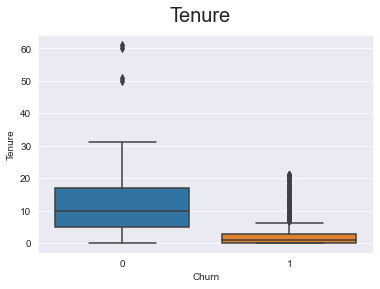

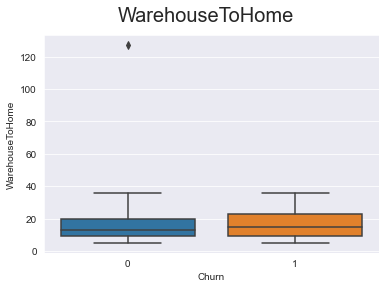

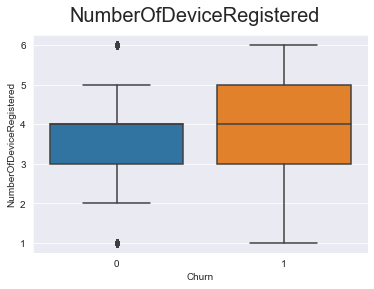

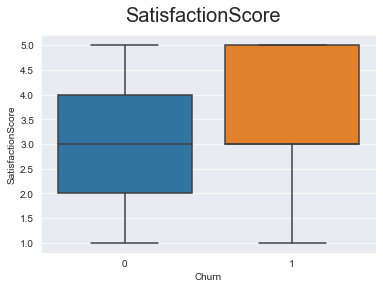

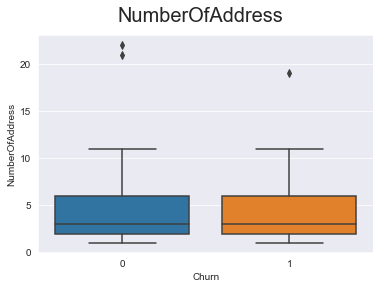

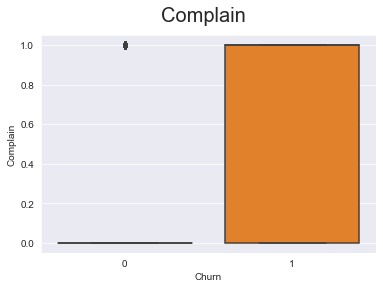

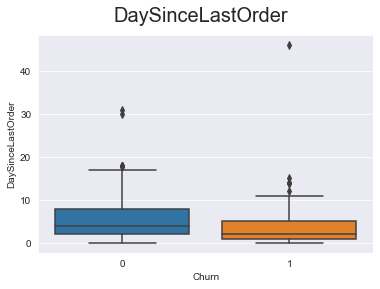

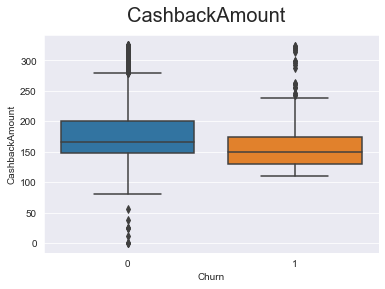

In [144]:
for col in df.describe(exclude='object').columns[:-1]:
    plt.suptitle(col, fontsize=20)
    sns.boxplot(data=df, y=col, x='Churn')
    plt.show()

Fitur yang diduga dapat menjadi prediktor yang baik adalah sebagai berikut.
- Tenure
- NumberOfDeciveRegistered
- SatisfactionScore
- Complain
- CashbackAmount

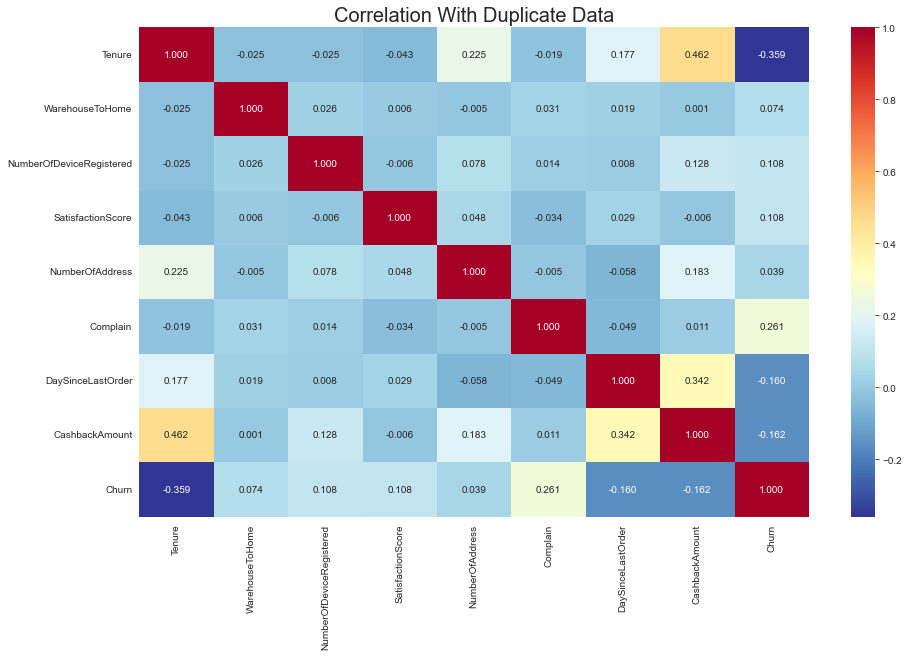

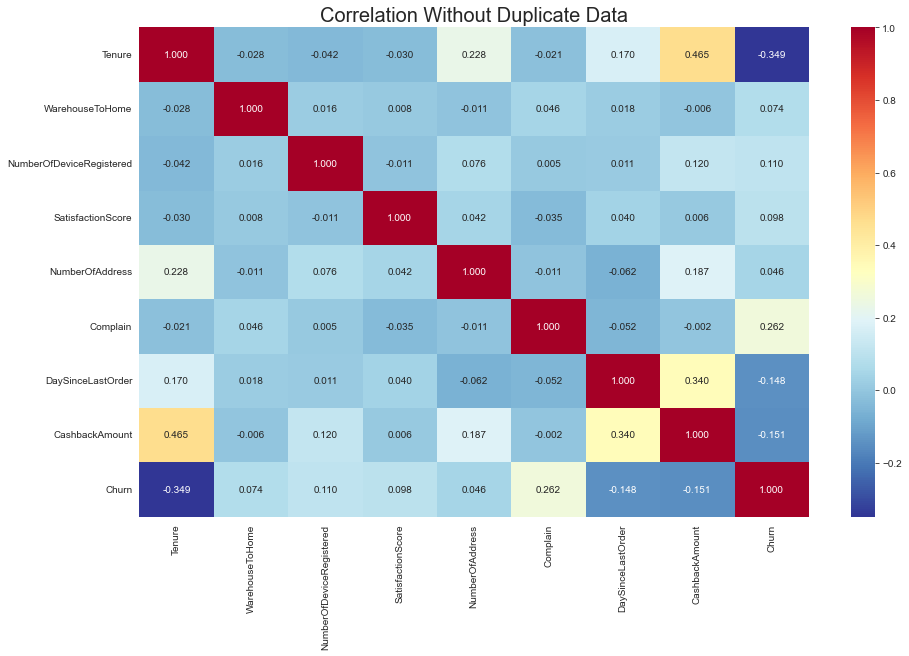

In [145]:
plt.figure(figsize=(15,9))
sns.heatmap(data=df.corr(method='pearson'), annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Correlation With Duplicate Data', fontsize=20)
plt.show()

plt.figure(figsize=(15,9))
sns.heatmap(data=df.drop_duplicates(subset=None, keep='first').corr(method='pearson'), annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Correlation Without Duplicate Data', fontsize=20)
plt.show()

- Tidak terdapat perubahan signifikan pada korelasi data setelah data duplikat dihapus.
- Korelasi yang paling tinggi pada target adalah fitur **Tenure**, ini dapat menjadi prediktor yang baik.

# Data Preparation

## Duplicate Data

Pertama kali yang dilakukan adalah menghapus data duplikat. Prosesnya adalah sebagai berikut.

In [180]:
df_new = df.copy()
df_no_duplicate = df.copy()
df_no_duplicate = df_no_duplicate.drop_duplicates(subset=None, keep='first').reset_index(drop=True)

print(f'Before removed: {df.shape}')
print(f'After removed: {df_no_duplicate.shape}')

Before removed: (3941, 11)
After removed: (3270, 11)


In [147]:
display(df.describe().T)
display(df_no_duplicate.describe().T)

,count,mean,std,min,25%,50%,75%,max
Tenure,3747.0,10.081398,8.498864,0.0,2.0,9.00,16.00,61.00
WarehouseToHome,3772.0,15.650583,8.452301,5.0,9.0,14.00,21.00,127.00
NumberOfDeviceRegistered,3941.0,3.679269,1.013938,1.0,3.0,4.00,4.00,6.00
SatisfactionScore,3941.0,3.088302,1.381832,1.0,2.0,3.00,4.00,5.00
NumberOfAddress,3941.0,4.237757,2.626699,1.0,2.0,3.00,6.00,22.00
Complain,3941.0,0.282416,0.450232,0.0,0.0,0.00,1.00,1.00
DaySinceLastOrder,3728.0,4.531652,3.667648,0.0,2.0,3.00,7.00,46.00
CashbackAmount,3941.0,176.707419,48.791784,0.0,145.7,163.34,195.25,324.99
Churn,3941.0,0.171023,0.376576,0.0,0.0,0.00,0.00,1.00


,count,mean,std,min,25%,50%,75%,max
Tenure,3110.0,10.190354,8.650821,0.0,2.0000,9.000,16.0000,61.00
WarehouseToHome,3135.0,15.510367,8.568382,5.0,9.0000,13.000,20.0000,127.00
NumberOfDeviceRegistered,3270.0,3.676453,1.017390,1.0,3.0000,4.000,4.0000,6.00
SatisfactionScore,3270.0,3.020795,1.395113,1.0,2.0000,3.000,4.0000,5.00
NumberOfAddress,3270.0,4.222936,2.623195,1.0,2.0000,3.000,6.0000,22.00
Complain,3270.0,0.281651,0.449873,0.0,0.0000,0.000,1.0000,1.00
DaySinceLastOrder,3089.0,4.545484,3.696022,0.0,2.0000,3.000,7.0000,46.00
CashbackAmount,3270.0,177.417670,49.310647,0.0,145.8925,163.885,197.1375,324.99
Churn,3270.0,0.163303,0.369698,0.0,0.0000,0.000,0.0000,1.00


## Outlier Handling

Setelah itu, kita akan coba menangani outlier. Kita akan mencoba untuk menghitung jumlah data yang terindikasi menjadi outlier. Jika terlalu banyak, kita tidak akan menghapus data ini karena data akan menjadi semakin sedikit untuk training dan testing.

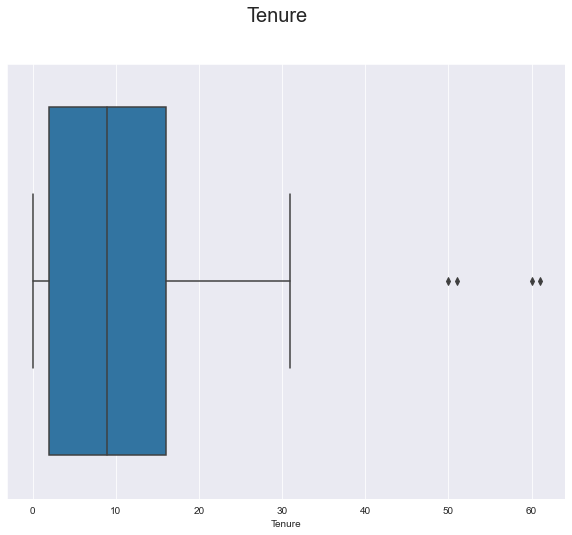

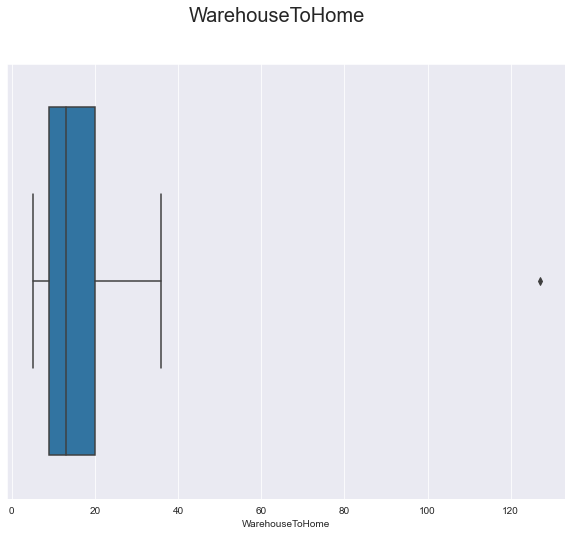

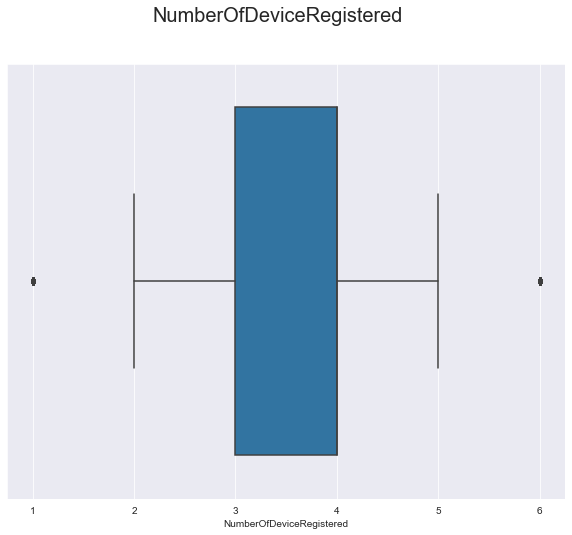

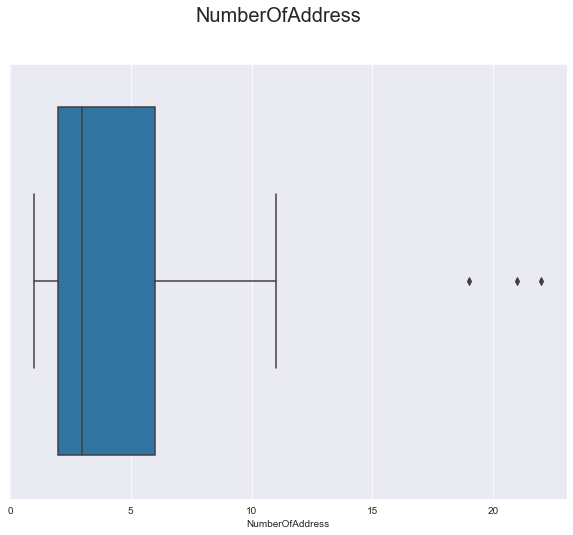

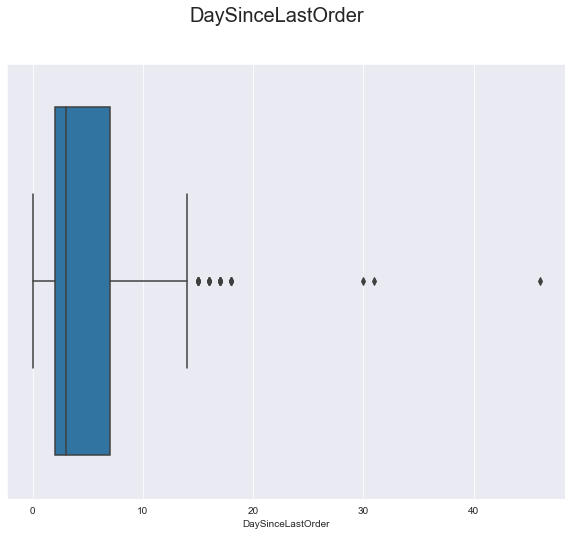

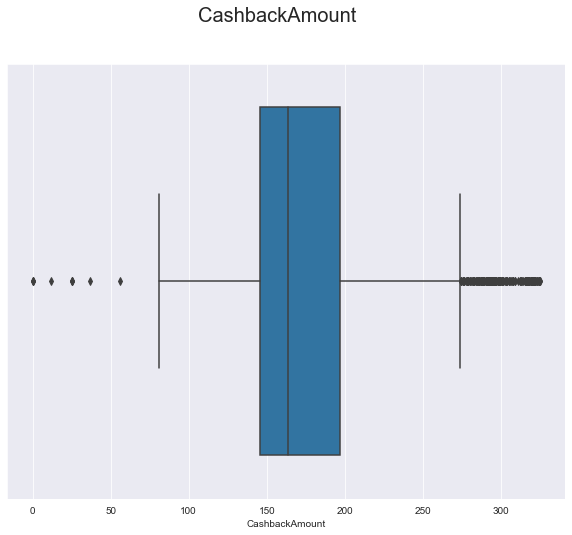

In [149]:
outlier_col = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']

# No duplicate
for col in outlier_col:
    plt.figure(figsize=(10,8))
    plt.suptitle(col, fontsize=20)
    sns.boxplot(data=df_no_duplicate, x=col)
    plt.show()

In [150]:
def outlier_handle(df, col):
    upper = []
    lower = []
    
    # IQR
    Q1 = df.describe()[col]['25%']
    Q3 = df.describe()[col]['75%']
    mini = df.describe()[col]['min']
    maxi = df.describe()[col]['max']
    IQR = Q3 - Q1
    upper_bound = Q3+1.5*IQR
    lower_bound = Q1-1.5*IQR

    print(f"Old Shape: {df.shape}")

    if maxi > upper_bound:
        upper = list(np.where(df[col] >= upper_bound)[0])
    else:
        upper_bound = maxi
        
    if mini < lower_bound:
        lower = list(np.where(df[col] <= lower_bound)[0])
    else:
        lower_bound = mini

    upper.extend(lower)
    df.drop(upper, inplace = True)
    
    print(f"New Shape: {df.shape}")
    print(f'Q1: {(Q1)}')
    print(f'Q3: {(Q3)}')
    print(f'IQR: {(IQR)}')
    print(f'Upper bound: {upper_bound}')
    print(f'Lower bound: {lower_bound}')
    
    print()
    return df.reset_index(drop=True)

df_outlier = df_no_duplicate.copy()
for i, col in enumerate(outlier_col):
    print(f'Column {col}::')
    df_outlier = outlier_handle(df_outlier, col)

Column Tenure::
Old Shape: (3270, 11)
New Shape: (3266, 11)
Q1: 2.0
Q3: 16.0
IQR: 14.0
Upper bound: 37.0
Lower bound: 0.0

Column WarehouseToHome::
Old Shape: (3266, 11)
New Shape: (3265, 11)
Q1: 9.0
Q3: 20.0
IQR: 11.0
Upper bound: 36.5
Lower bound: 5.0

Column NumberOfDeviceRegistered::
Old Shape: (3265, 11)
New Shape: (3040, 11)
Q1: 3.0
Q3: 4.0
IQR: 1.0
Upper bound: 5.5
Lower bound: 1.5

Column NumberOfAddress::
Old Shape: (3040, 11)
New Shape: (3037, 11)
Q1: 2.0
Q3: 6.0
IQR: 4.0
Upper bound: 12.0
Lower bound: 1.0

Column DaySinceLastOrder::
Old Shape: (3037, 11)
New Shape: (2998, 11)
Q1: 2.0
Q3: 7.0
IQR: 5.0
Upper bound: 14.5
Lower bound: 0.0

Column CashbackAmount::
Old Shape: (2998, 11)
New Shape: (2771, 11)
Q1: 145.93
Q3: 196.76
IQR: 50.829999999999984
Upper bound: 273.005
Lower bound: 69.68500000000003



In [151]:
print(f'First dataframe shape: {df_new.shape}')
print(f'Dataframe after duplicate handle shape: {df_no_duplicate.shape}')
print(f'Dataframe after duplicate, without outlier shape: {df_outlier.shape}')

First dataframe shape: (3941, 11)
Dataframe after duplicate handle shape: (3270, 11)
Dataframe after duplicate, without outlier shape: (2771, 11)


Dapat terlihat bahwa dataset setelah outlier handling hanya tersisa 2771 yang dapat terbilang sangat sedikit untuk classification modelling. Oleh karena itu kita tidak akan menghapus data outlier.

## Missing Value Check

Missing value terdapat pada fitur:
- 'DaySinceLastOrder'
- 'Tenure'
- 'WarehouseToHome'

Kita akan coba membandingkan beberapa metode imputer seperti:
- Simple imputer dengan mean
- Simple imputer dengan median
- KNN Imputer dengan n_neighbors = 3
- KNN Imputer dengan n_neighbors = 5
- Iterative Imputer / MICE

Yang akan kita bandingkan adalah mean dan standar deviasi. Perbandingan dilakukan sebelum dan setelah dilakukan imputer. Metode yang akan digunakan adalah metode dengan nilai mean dan standar deviasinya mendekati populasi sebelum data dilakukan imputer.

In [152]:
def missing_value_handle(alg):
    missing_col = ['DaySinceLastOrder', 'Tenure', 'WarehouseToHome']
    df_new_2 = df_no_duplicate.copy()
    
    # Imputer initialization
    if alg == 'mean':
        algo = SimpleImputer(missing_values = np.nan, strategy ='mean')
    elif alg == 'median':
        algo = SimpleImputer(missing_values = np.nan, strategy ='median')
    elif alg == 'knn3':
        algo = KNNImputer(n_neighbors=3)
    elif alg == 'knn5':
        algo = KNNImputer(n_neighbors=5)
    elif alg == 'iterative':
        algo = IterativeImputer(random_state=0)

    # Fit & Transform
    algo.fit(df_new_2[missing_col])
    algo = algo.transform(df_new_2[missing_col])
    
    df = pd.DataFrame(columns = missing_col,
                      data = algo)
    df_new_2[missing_col] = algo
    
    return df_new_2

# Put in dataframe
missing_col = ['DaySinceLastOrder', 'Tenure', 'WarehouseToHome']
df_new_2 = df_no_duplicate.copy()

# MEAN
df_si_mean = missing_value_handle('mean')

# MEDIAN
df_si_median = missing_value_handle('median')

# KNN-3
df_knn3 = missing_value_handle('knn3')

# KNN-5
df_knn5 = missing_value_handle('knn5')

# ITERATIVE IMPUTER
df_iterative_imp = missing_value_handle('iterative')

In [153]:
# Recalculate
def calculate(df, metrics):
    if metrics == 'std':
        return  round(df['DaySinceLastOrder'].std(), 2), round(df['Tenure'].std(), 2), round(df['WarehouseToHome'].std(), 2)
    else:
        return  round(df['DaySinceLastOrder'].mean(), 2), round(df['Tenure'].mean(), 2), round(df['WarehouseToHome'].mean(), 2)
    
# Calculate standard with missing value
day_mean = round(df_new_2['DaySinceLastOrder'].mean(), 2)
day_std = round(df_new_2['DaySinceLastOrder'].std(), 2)

tenure_mean = round(df_new_2['Tenure'].mean(), 2)
tenure_std = round(df_new_2['Tenure'].std(), 2)

warehouse_mean = round(df_new_2['WarehouseToHome'].mean(), 2)
warehouse_std = round(df_new_2['WarehouseToHome'].std(), 2)

# MEAN
day_mean_si_mean, tenure_mean_si_mean, warehouse_mean_si_mean = calculate(df_si_mean, 'mean')
day_std_si_mean, tenure_std_si_mean, warehouse_std_si_mean = calculate(df_si_mean, 'std')

# MEDIAN
day_mean_si_median, tenure_mean_si_median, warehouse_mean_si_median = calculate(df_si_median, 'mean')
day_std_si_median, tenure_std_si_median, warehouse_std_si_median = calculate(df_si_median, 'std')

# KNN3
day_mean_si_knn3, tenure_mean_si_knn3, warehouse_mean_si_knn3 = calculate(df_knn3, 'mean')
day_std_si_knn3, tenure_std_si_knn3, warehouse_std_si_knn3 = calculate(df_knn3, 'std')

# KNN5
day_mean_si_knn5, tenure_mean_si_knn5, warehouse_mean_si_knn5 = calculate(df_knn5, 'mean')
day_std_si_knn5, tenure_std_si_knn5, warehouse_std_si_knn5 = calculate(df_knn5, 'std')

# ITERATIVE IMPUTER
day_mean_si_iterative_imp, tenure_mean_si_iterative_imp, warehouse_mean_si_iterative_imp = calculate(df_iterative_imp, 'mean')
day_std_si_iterative_imp, tenure_std_si_iterative_imp, warehouse_std_si_iterative_imp = calculate(df_iterative_imp, 'std')

,Columns Name,Mean Value Before,Mean Value After,Std Value Before,Std Value After
Kind of Imputers,,,,,
Simple Imputer W/ Mean,DaySinceLastOrder,4.55,4.55,3.70,3.59
Simple Imputer W/ Mean,Tenure,10.19,10.19,8.65,8.44
Simple Imputer W/ Mean,WarehouseToHome,15.51,15.51,8.57,8.39
Simple Imputer W/ Median,DaySinceLastOrder,4.55,4.46,3.70,3.61
Simple Imputer W/ Median,Tenure,10.19,10.13,8.65,8.44
Simple Imputer W/ Median,WarehouseToHome,15.51,15.41,8.57,8.40
KNN Imputer 3,DaySinceLastOrder,4.55,4.44,3.70,3.64
KNN Imputer 3,Tenure,10.19,10.06,8.65,8.52
KNN Imputer 3,WarehouseToHome,15.51,15.40,8.57,8.46


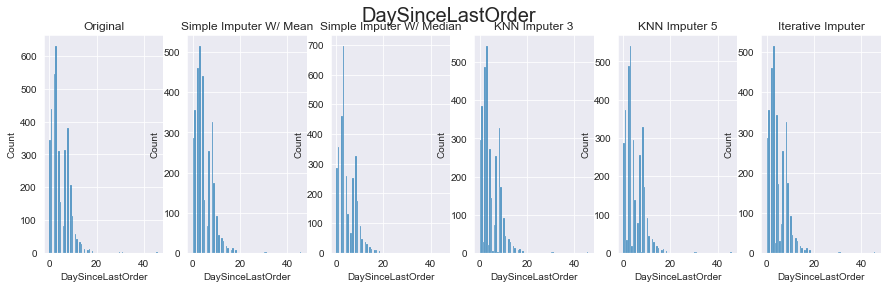

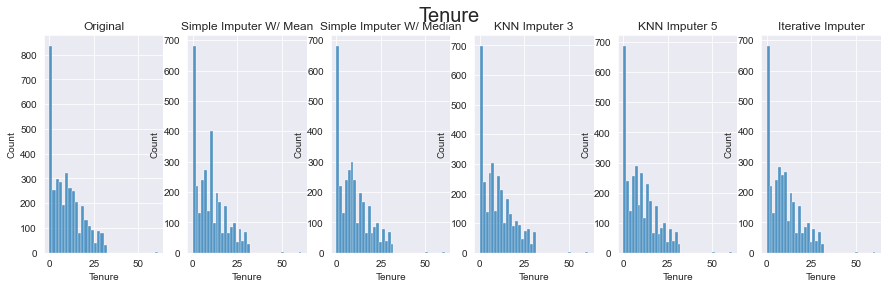

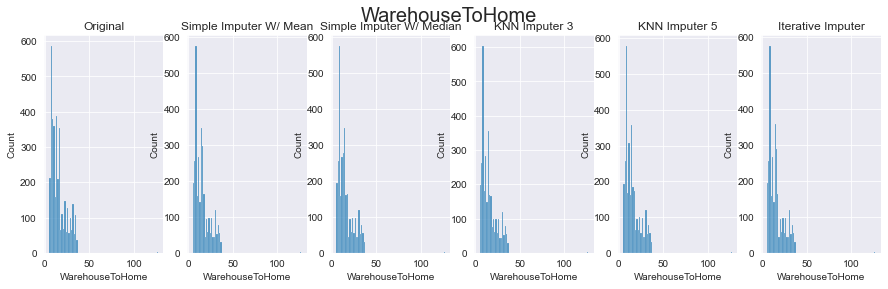

In [154]:
yuhu_df = pd.DataFrame(columns = ['Columns Name', 'Kind of Imputers', 'Mean Value Before', 'Mean Value After', 'Std Value Before', 'Std Value After'],
                       data = [['DaySinceLastOrder', 'Simple Imputer W/ Mean', day_mean, day_mean_si_mean, day_std, day_std_si_mean], 
                               ['Tenure', 'Simple Imputer W/ Mean', tenure_mean, tenure_mean_si_mean, tenure_std, tenure_std_si_mean], 
                               ['WarehouseToHome', 'Simple Imputer W/ Mean', warehouse_mean, warehouse_mean_si_mean, warehouse_std, warehouse_std_si_mean],
                               
                               ['DaySinceLastOrder', 'Simple Imputer W/ Median', day_mean, day_mean_si_median, day_std, day_std_si_median], 
                               ['Tenure', 'Simple Imputer W/ Median', tenure_mean, tenure_mean_si_median, tenure_std, tenure_std_si_median], 
                               ['WarehouseToHome', 'Simple Imputer W/ Median', warehouse_mean, warehouse_mean_si_median, warehouse_std, warehouse_std_si_median],
                               
                               ['DaySinceLastOrder', 'KNN Imputer 3', day_mean, day_mean_si_knn3, day_std, day_std_si_knn3], 
                               ['Tenure', 'KNN Imputer 3', tenure_mean, tenure_mean_si_knn3, tenure_std, tenure_std_si_knn3], 
                               ['WarehouseToHome', 'KNN Imputer 3', warehouse_mean, warehouse_mean_si_knn3, warehouse_std, warehouse_std_si_knn3],
                               
                               ['DaySinceLastOrder', 'KNN Imputer 5', day_mean, day_mean_si_knn5, day_std, day_std_si_knn5], 
                               ['Tenure', 'KNN Imputer 5', tenure_mean, tenure_mean_si_knn5, tenure_std, tenure_std_si_knn5], 
                               ['WarehouseToHome', 'KNN Imputer 5', warehouse_mean, warehouse_mean_si_knn5, warehouse_std, warehouse_std_si_knn5],
                               
                               ['DaySinceLastOrder', 'Iterative Imputer', day_mean, day_mean_si_iterative_imp, day_std, day_std_si_iterative_imp], 
                               ['Tenure', 'Iterative Imputer', tenure_mean, tenure_mean_si_iterative_imp, tenure_std, tenure_std_si_iterative_imp], 
                               ['WarehouseToHome', 'Iterative Imputer', warehouse_mean, warehouse_mean_si_iterative_imp, warehouse_std, warehouse_std_si_iterative_imp]])

display(yuhu_df.set_index('Kind of Imputers'))

for col in missing_col:
    fig, axes = plt.subplots(1, 6, figsize=(15,4))
    plt.suptitle(col, fontsize=20)
    
    sns.histplot(data=df_new, x=col, ax=axes[0])
    sns.histplot(data=df_si_mean, x=col, ax=axes[1])
    sns.histplot(data=df_si_median, x=col, ax=axes[2])
    sns.histplot(data=df_knn3, x=col, ax=axes[3])
    sns.histplot(data=df_knn5, x=col, ax=axes[4])
    sns.histplot(data=df_iterative_imp, x=col, ax=axes[5])
    
    axes[0].title.set_text('Original')
    axes[1].title.set_text('Simple Imputer W/ Mean')
    axes[2].title.set_text('Simple Imputer W/ Median')
    axes[3].title.set_text('KNN Imputer 3')
    axes[4].title.set_text('KNN Imputer 5')
    axes[5].title.set_text('Iterative Imputer')
    
    plt.show()

Yang paling baik dan mendekati distribusi asli dengan missing value yaitu handling menggunakan KNN Imputer dengan k = 3. Untuk selanjutnya metode ini akan dimasukkan ke dalam pipeline untuk mempermudah imputasi.

## Encoding & Splitting data

In [155]:
df_new_3_no_miss = df_knn3.copy()
df_new_3 = df_new_2.copy()

df_new_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3110 non-null   float64
 1   WarehouseToHome           3135 non-null   float64
 2   NumberOfDeviceRegistered  3270 non-null   int64  
 3   PreferedOrderCat          3270 non-null   object 
 4   SatisfactionScore         3270 non-null   int64  
 5   MaritalStatus             3270 non-null   object 
 6   NumberOfAddress           3270 non-null   int64  
 7   Complain                  3270 non-null   int64  
 8   DaySinceLastOrder         3089 non-null   float64
 9   CashbackAmount            3270 non-null   float64
 10  Churn                     3270 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 281.1+ KB


Data yang akan diencoding adalah:
- 'PreferedOrderCat'
- 'MaritalStatus'

Data dengan missing value adalah:
- 'Tenure'
- 'WarehouseToHome'
- 'DaySinceLastOrder'

Setelah kita menetapkan column transformer, kita akan membagi data untuk training dan testing dengan proporsi sebesar (80%:20%).

In [157]:
encoded_feature = ['PreferedOrderCat', 'MaritalStatus']
missing_feature = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']

oht = OneHotEncoder(drop='first')
miss_val_handle = KNNImputer(n_neighbors=3)

preprocessor = ColumnTransformer([
    ('miss', miss_val_handle, missing_feature),
    ('enc', oht, encoded_feature),
], remainder='passthrough')

x = df_new_3.drop(columns=['Churn'])
y = df_new_3['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=2022)

## Model Benchmarking: Training and Testing

Setelah itu kita akan mencoba melakukan modelling (training dan testing) dengan berbagai metode dengan parameter default.

In [158]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dec_tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier(verbosity=0, silent=True)
lgbm = lgb.LGBMClassifier()
catb = CatBoostClassifier(silent=True)
adab = AdaBoostClassifier()

models = [logreg, knn, dec_tree, rf, xgb, lgbm, catb, adab]
algoritma = ['Logistic Regression', 'KNN', 'Decision Tree', 'RF', 'XGBoost', 'LightGBM', 'Catboost', 'Adaboost']

In [159]:
# Training
score_training = []
average_score_training = []
std_dev_training = []

for model in models:
    sk_fold = StratifiedKFold(n_splits=5)
    pipeline_model = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    model_cv = cross_val_score(pipeline_model, 
                               x_train,
                               y_train,
                               cv=sk_fold,
                               scoring='roc_auc')
    
    score_training.append([round(i, 2) for i in model_cv])
    average_score_training.append(model_cv.mean())
    std_dev_training.append(model_cv.std())
    
df_default_train = pd.DataFrame(data={'Algorithm': algoritma,
                                      'Average of ROC AUC': average_score_training,
                                      'Standard Deviation of ROC AUC': std_dev_training,
                                      'Each ROC AUC Score': score_training,})

In [160]:
# Testing
roc_auc_score_testing = []
recall_score_testing = []
class_report_testing = []
confus_matrix_testing = []
fpr_testing = []

for i, model in enumerate(models):    
    pipeline_model = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    pipeline_model.fit(x_train, y_train)
    
    y_pred = pipeline_model.predict(x_test)
    y_pred_proba = pipeline_model.predict_proba(x_test)[:,1]
    confus_matrix_var = confusion_matrix(y_test, y_pred)
    
    roc_auc_score_testing.append(roc_auc_score(y_test, y_pred_proba))
    recall_score_testing.append(recall_score(y_test, y_pred))
    class_report_testing.append(classification_report(y_test, y_pred))
    confus_matrix_testing.append(confus_matrix_var)
    fpr_testing.append(confus_matrix_var[0][1]/(confus_matrix_var[0][1]+confus_matrix_var[0][0]))
    
df_default_test = pd.DataFrame(data={'Algorithm': algoritma,
                                     'ROC AUC Score': roc_auc_score_testing,
                                     'Recall Score': recall_score_testing,
                                     'FPR': fpr_testing,})

In [161]:
display(df_default_train)
display(df_default_test)

for i, model in enumerate(models):
    print(f'Algorithm: {algoritma[i]}\n {class_report_testing[i]}')
    print(f'{confus_matrix_testing[i]}\n')

,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each ROC AUC Score
0,Logistic Regression,0.878656,0.019566,"[0.87, 0.88, 0.89, 0.91, 0.85]"
1,KNN,0.781599,0.031585,"[0.73, 0.82, 0.76, 0.81, 0.78]"
2,Decision Tree,0.766987,0.033623,"[0.73, 0.8, 0.77, 0.8, 0.73]"
3,RF,0.919471,0.017235,"[0.89, 0.94, 0.92, 0.94, 0.91]"
4,XGBoost,0.931963,0.014313,"[0.91, 0.94, 0.93, 0.95, 0.93]"
5,LightGBM,0.932376,0.012493,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.934274,0.014797,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.897741,0.018294,"[0.88, 0.91, 0.89, 0.93, 0.88]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.869996,0.504673,0.049360
1,KNN,0.788131,0.411215,0.040219
2,Decision Tree,0.843872,0.766355,0.078611
3,RF,0.946984,0.588785,0.029250
4,XGBoost,0.944199,0.710280,0.038391
5,LightGBM,0.945993,0.728972,0.031079
6,Catboost,0.944233,0.691589,0.038391
7,Adaboost,0.886996,0.504673,0.049360


Algorithm: Logistic Regression
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       547
           1       0.67      0.50      0.57       107

    accuracy                           0.88       654
   macro avg       0.79      0.73      0.75       654
weighted avg       0.87      0.88      0.87       654

[[520  27]
 [ 53  54]]

Algorithm: KNN
               precision    recall  f1-score   support

           0       0.89      0.96      0.93       547
           1       0.67      0.41      0.51       107

    accuracy                           0.87       654
   macro avg       0.78      0.69      0.72       654
weighted avg       0.86      0.87      0.86       654

[[525  22]
 [ 63  44]]

Algorithm: Decision Tree
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       547
           1       0.66      0.77      0.71       107

    accuracy                           0.90       654
   mac

Algoritma yang memiliki nilai ROC-AUC tinggi, recall tinggi, dan FPR rendah adalah XGBoost dan LightGBM. Setelah itu kita akan mencoba mengekstrak feature importance dari algoritma yang dipilih.

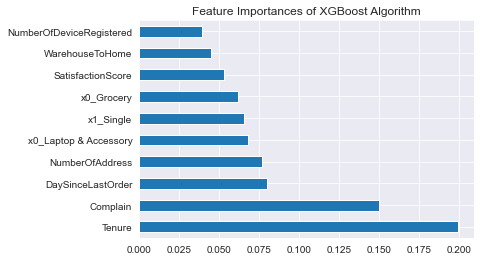

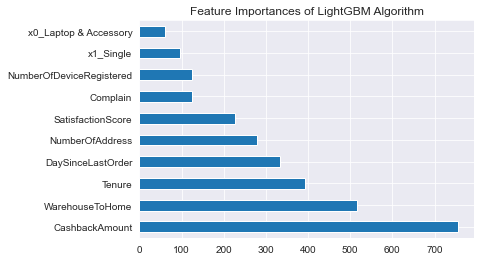

In [162]:
mods = [xgb, lgbm]
mods_title = ['XGBoost', 'LightGBM']
feature_final = missing_feature + pipeline_model['preprocess'].transformers_[1][1].get_feature_names().tolist() + ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount']

for i, model in enumerate(mods):
    pipeline_model = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    pipeline_model.fit(x_train, y_train)
    
    feat_imp = pd.Series(pipeline_model['model'].feature_importances_, feature_final)\
               .sort_values(ascending = False).head(10)
    feat_imp.plot(kind='barh', title=f'Feature Importances of {mods_title[i]} Algorithm')
    plt.show()

Dapat kita lihat fitur **Tenure** masuk ke dalam Top 3 model.

## Feature Engineering With Polynomial

Karena fitur yang ada pada data hanya sedikit yaitu 10, kita akan mencoba melakukan **feature engineering** dengan metode polynomial. Kita akan mencoba dengan parameter degree yaitu 2 dan 3 pada semua fitur numerikal secara satu per satu lalu akan dibandingkan skor yang diperoleh.

In [163]:
def split_before_generating_feature():
    # split before sampling
    x_poli, x_test_poli, y_poli, y_test_poli = train_test_split(x_no_miss,
                                                                y_no_miss, 
                                                                stratify=y_no_miss,
                                                                test_size=0.2,
                                                                random_state=2022)
    
    return x_poli, x_test_poli, y_poli, y_test_poli


def training_testing_in_generating_feature(col_used, degree, x_train, x_test, y_train, y_test):
    # -- training
    score_training = []
    score_avg_training = []
    std_dev_training = []
    fpr_training = []
    
    # -- testing
    recall_testing = []
    fpr_testing = []
    roc_auc_testing = []
    class_report_testing = []
    confus_matrix_testing = []
    
        
    # Fitting polynomial
    if(len(col_used) == 1):
        col_used2 = ['x0']
    elif(len(col_used) == 2):
        col_used2 = ['x0', 'x1']
    elif(len(col_used) == 3):
        col_used2 = ['x0', 'x1', 'x2']
    elif(len(col_used) == 4):
        col_used2 = ['x0', 'x1', 'x2', 'x3']
        
    poli = PolynomialFeatures(degree=degree)
    poli_cols = col_used

    x_train_poli = poli.fit_transform(x_train[col_used])
    x_test_poli = poli.transform(x_test[col_used])

    x_train_poli_append = pd.DataFrame(data=x_train_poli, columns=poli.get_feature_names()).drop(columns=col_used2)
    x_test_poli_append = pd.DataFrame(data=x_test_poli, columns=poli.get_feature_names()).drop(columns=col_used2)

    x_train_poli = pd.concat([x_train.reset_index(drop=True), x_train_poli_append], axis=1)
    x_test_poli = pd.concat([x_test.reset_index(drop=True), x_test_poli_append], axis=1)

    y_train_poli = y_train.copy()
    y_test_poli = y_test.copy()
    
    # Training w/ balanced dataset
    for model in models:
        sk_fold = StratifiedKFold(n_splits=5)
        pipeline_model = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])

        model_cv=cross_val_score(pipeline_model, 
                                 x_train_poli,
                                 y_train_poli,
                                 cv=sk_fold,
                                 scoring='roc_auc')

        score_training.append([round(i, 2) for i in model_cv])
        score_avg_training.append(model_cv.mean())
        std_dev_training.append(model_cv.std())

    df_train = pd.DataFrame(data={'Algorithm': algoritma,
                                  'Average of ROC AUC': score_avg_training,
                                  'Standard Deviation of ROC AUC': std_dev_training,
                                  'Each of ROC AUC Score': score_training})

    # Testing
    for i, model in enumerate(models):
        pipeline_model = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])

        pipeline_model.fit(x_train_poli, y_train_poli)

        y_pred = pipeline_model.predict(x_test_poli)
        y_pred_proba = pipeline_model.predict_proba(x_test_poli)[:,1]
        confus_matrix_var = confusion_matrix(y_test_poli, y_pred)

        recall_testing.append(recall_score(y_test_poli, y_pred))
        fpr_testing.append(confus_matrix_var[0][1]/(confus_matrix_var[0][1]+confus_matrix_var[0][0]))
        roc_auc_testing.append(roc_auc_score(y_test_poli, y_pred_proba))
        confus_matrix_testing.append(confus_matrix_var)
        class_report_testing.append(classification_report(y_test_poli, y_pred))
        

    df_test = pd.DataFrame(data={'Algorithm': algoritma,
                                 'ROC AUC Score': roc_auc_testing,
                                 'Recall Score': recall_testing,
                                 'FPR': fpr_testing,})
    
    return df_train, df_test, class_report_testing, confus_matrix_testing

x_no_miss = df_new_3_no_miss.drop(columns=['Churn'])
y_no_miss = df_new_3_no_miss['Churn']

x_train_poli, x_test_poli, y_train_poli, y_test_poli = split_before_generating_feature()


### Polynomial Degree 2

In [164]:
for col in df.describe().columns.tolist()[:-1]:
    df_train_poli, df_test_poli, classif_report_poli, confusion_matrix_poli = training_testing_in_generating_feature([col], 2, x_train_poli, x_test_poli, y_train_poli, y_test_poli)
    
    print(f'\n------------------------------{col}------------------------------')
    display(df_train_poli)
    display(df_test_poli)



------------------------------Tenure------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.867099,0.018148,"[0.85, 0.87, 0.87, 0.9, 0.85]"
1,KNN,0.808040,0.019349,"[0.77, 0.82, 0.81, 0.83, 0.81]"
2,Decision Tree,0.767635,0.040525,"[0.7, 0.81, 0.77, 0.81, 0.76]"
3,RF,0.928263,0.014500,"[0.92, 0.94, 0.91, 0.95, 0.93]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.933667,0.016015,"[0.91, 0.94, 0.93, 0.96, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.853440,0.420561,0.056673
1,KNN,0.824651,0.504673,0.045704
2,Decision Tree,0.822438,0.728972,0.084095
3,RF,0.938808,0.598131,0.032907
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.941414,0.654206,0.038391
7,Adaboost,0.883596,0.514019,0.053016



------------------------------WarehouseToHome------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.855172,0.021516,"[0.83, 0.86, 0.85, 0.89, 0.84]"
1,KNN,0.742626,0.018421,"[0.72, 0.73, 0.73, 0.77, 0.76]"
2,Decision Tree,0.771592,0.031063,"[0.72, 0.8, 0.76, 0.81, 0.77]"
3,RF,0.924509,0.015725,"[0.9, 0.93, 0.91, 0.95, 0.93]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.930688,0.015963,"[0.9, 0.93, 0.93, 0.95, 0.94]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.849357,0.429907,0.056673
1,KNN,0.685071,0.168224,0.063985
2,Decision Tree,0.814007,0.710280,0.082267
3,RF,0.938253,0.598131,0.025594
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.945378,0.691589,0.031079
7,Adaboost,0.883596,0.514019,0.053016



------------------------------NumberOfDeviceRegistered------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.872463,0.017434,"[0.87, 0.88, 0.87, 0.9, 0.84]"
1,KNN,0.778620,0.035836,"[0.75, 0.82, 0.76, 0.82, 0.75]"
2,Decision Tree,0.773999,0.040075,"[0.7, 0.8, 0.8, 0.81, 0.76]"
3,RF,0.920596,0.018189,"[0.9, 0.93, 0.91, 0.95, 0.91]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.930663,0.014439,"[0.91, 0.93, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.860753,0.457944,0.053016
1,KNN,0.808975,0.299065,0.043876
2,Decision Tree,0.812990,0.700935,0.074954
3,RF,0.939389,0.607477,0.034735
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.941738,0.644860,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------SatisfactionScore------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.870415,0.017871,"[0.86, 0.87, 0.88, 0.9, 0.84]"
1,KNN,0.765799,0.020544,"[0.75, 0.8, 0.75, 0.78, 0.74]"
2,Decision Tree,0.766760,0.039065,"[0.72, 0.8, 0.75, 0.82, 0.74]"
3,RF,0.923029,0.016837,"[0.91, 0.94, 0.9, 0.94, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.932092,0.016235,"[0.91, 0.94, 0.93, 0.96, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.865571,0.467290,0.043876
1,KNN,0.789660,0.271028,0.043876
2,Decision Tree,0.835441,0.747664,0.076782
3,RF,0.949487,0.588785,0.027422
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.943430,0.672897,0.032907
7,Adaboost,0.883596,0.514019,0.053016



------------------------------NumberOfAddress------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.872016,0.017966,"[0.86, 0.87, 0.88, 0.9, 0.85]"
1,KNN,0.753083,0.022746,"[0.73, 0.77, 0.74, 0.79, 0.73]"
2,Decision Tree,0.782662,0.042330,"[0.71, 0.81, 0.79, 0.84, 0.76]"
3,RF,0.921355,0.014057,"[0.9, 0.93, 0.91, 0.94, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931684,0.013965,"[0.91, 0.93, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.865776,0.457944,0.049360
1,KNN,0.773924,0.261682,0.049360
2,Decision Tree,0.826197,0.738318,0.085923
3,RF,0.946249,0.607477,0.031079
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.944745,0.644860,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------Complain------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.875521,0.016624,"[0.87, 0.88, 0.89, 0.9, 0.85]"
1,KNN,0.781391,0.031697,"[0.73, 0.82, 0.77, 0.81, 0.77]"
2,Decision Tree,0.765106,0.035238,"[0.71, 0.79, 0.77, 0.81, 0.74]"
3,RF,0.921742,0.011918,"[0.91, 0.94, 0.91, 0.93, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.930720,0.014814,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.867587,0.448598,0.049360
1,KNN,0.807027,0.420561,0.045704
2,Decision Tree,0.806489,0.691589,0.078611
3,RF,0.936672,0.607477,0.031079
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.943754,0.644860,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------DaySinceLastOrder------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.875413,0.016271,"[0.86, 0.88, 0.88, 0.9, 0.85]"
1,KNN,0.754115,0.036147,"[0.71, 0.77, 0.75, 0.81, 0.73]"
2,Decision Tree,0.755064,0.039682,"[0.68, 0.79, 0.77, 0.79, 0.75]"
3,RF,0.923424,0.014433,"[0.9, 0.93, 0.91, 0.94, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.930452,0.013837,"[0.91, 0.93, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.868219,0.476636,0.043876
1,KNN,0.789788,0.336449,0.040219
2,Decision Tree,0.818680,0.719626,0.082267
3,RF,0.940329,0.588785,0.034735
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.942541,0.672897,0.036563
7,Adaboost,0.883596,0.514019,0.053016



------------------------------CashbackAmount------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.830360,0.023510,"[0.82, 0.84, 0.84, 0.86, 0.79]"
1,KNN,0.596149,0.042895,"[0.52, 0.63, 0.58, 0.62, 0.63]"
2,Decision Tree,0.775364,0.033209,"[0.71, 0.8, 0.78, 0.81, 0.77]"
3,RF,0.919384,0.016670,"[0.9, 0.93, 0.91, 0.95, 0.91]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931436,0.013693,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.811871,0.261682,0.025594
1,KNN,0.668634,0.158879,0.038391
2,Decision Tree,0.816851,0.719626,0.085923
3,RF,0.940551,0.570093,0.031079
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.942712,0.644860,0.032907
7,Adaboost,0.883596,0.514019,0.053016


### Polynomial Degree 3

In [165]:
for col in df.describe().columns.tolist()[:-1]:
    df_train_poli, df_test_poli, classif_report_poli, confusion_matrix_poli = training_testing_in_generating_feature([col], 3, x_train_poli, x_test_poli, y_train_poli, y_test_poli)
    
    print(f'\n------------------------------{col}------------------------------')
    display(df_train_poli)
    display(df_test_poli)



------------------------------Tenure------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.859695,0.015587,"[0.84, 0.87, 0.87, 0.88, 0.84]"
1,KNN,0.812901,0.016423,"[0.79, 0.81, 0.82, 0.84, 0.81]"
2,Decision Tree,0.774512,0.035352,"[0.74, 0.78, 0.8, 0.82, 0.73]"
3,RF,0.928142,0.019286,"[0.91, 0.95, 0.9, 0.95, 0.93]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.933502,0.013212,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.837636,0.448598,0.049360
1,KNN,0.819466,0.504673,0.043876
2,Decision Tree,0.827111,0.738318,0.084095
3,RF,0.935237,0.626168,0.034735
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.942319,0.663551,0.036563
7,Adaboost,0.883596,0.514019,0.053016



------------------------------WarehouseToHome------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.822330,0.024395,"[0.8, 0.83, 0.83, 0.86, 0.79]"
1,KNN,0.741141,0.016473,"[0.72, 0.73, 0.74, 0.76, 0.76]"
2,Decision Tree,0.775170,0.040787,"[0.71, 0.8, 0.79, 0.82, 0.75]"
3,RF,0.921374,0.014440,"[0.9, 0.94, 0.91, 0.94, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.932202,0.014812,"[0.91, 0.94, 0.92, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.814878,0.280374,0.034735
1,KNN,0.680594,0.158879,0.063985
2,Decision Tree,0.812076,0.700935,0.076782
3,RF,0.938936,0.616822,0.023766
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.941892,0.663551,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------NumberOfDeviceRegistered------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.868279,0.017445,"[0.86, 0.87, 0.87, 0.9, 0.84]"
1,KNN,0.767728,0.028696,"[0.74, 0.8, 0.76, 0.8, 0.74]"
2,Decision Tree,0.777466,0.030789,"[0.73, 0.8, 0.78, 0.82, 0.77]"
3,RF,0.919292,0.015233,"[0.9, 0.93, 0.91, 0.94, 0.91]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.932312,0.015959,"[0.91, 0.94, 0.93, 0.96, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.855730,0.448598,0.049360
1,KNN,0.799057,0.280374,0.042048
2,Decision Tree,0.817663,0.710280,0.074954
3,RF,0.934913,0.570093,0.023766
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.942883,0.672897,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------SatisfactionScore------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.873246,0.015972,"[0.87, 0.88, 0.88, 0.9, 0.85]"
1,KNN,0.745502,0.018134,"[0.74, 0.76, 0.76, 0.76, 0.71]"
2,Decision Tree,0.774248,0.035741,"[0.72, 0.8, 0.79, 0.82, 0.75]"
3,RF,0.925345,0.015659,"[0.91, 0.94, 0.91, 0.95, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.933889,0.015708,"[0.91, 0.94, 0.93, 0.96, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.856909,0.420561,0.047532
1,KNN,0.765356,0.252336,0.043876
2,Decision Tree,0.811162,0.700935,0.078611
3,RF,0.944139,0.607477,0.031079
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.942558,0.644860,0.032907
7,Adaboost,0.883596,0.514019,0.053016



------------------------------NumberOfAddress------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.855721,0.022753,"[0.83, 0.86, 0.85, 0.9, 0.84]"
1,KNN,0.747964,0.022240,"[0.72, 0.76, 0.74, 0.78, 0.73]"
2,Decision Tree,0.766540,0.039805,"[0.7, 0.8, 0.78, 0.81, 0.74]"
3,RF,0.920690,0.016483,"[0.91, 0.94, 0.9, 0.94, 0.91]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931544,0.014349,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.853372,0.392523,0.042048
1,KNN,0.787174,0.280374,0.047532
2,Decision Tree,0.810248,0.700935,0.080439
3,RF,0.939432,0.588785,0.032907
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.944557,0.644860,0.032907
7,Adaboost,0.883596,0.514019,0.053016



------------------------------Complain------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.872030,0.019030,"[0.86, 0.88, 0.88, 0.9, 0.84]"
1,KNN,0.785925,0.034507,"[0.73, 0.83, 0.78, 0.81, 0.78]"
2,Decision Tree,0.768863,0.042265,"[0.7, 0.8, 0.77, 0.82, 0.75]"
3,RF,0.922730,0.012635,"[0.91, 0.94, 0.92, 0.94, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931437,0.015724,"[0.91, 0.94, 0.93, 0.96, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.854773,0.467290,0.054845
1,KNN,0.812238,0.429907,0.043876
2,Decision Tree,0.816851,0.719626,0.085923
3,RF,0.935365,0.570093,0.034735
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.943293,0.644860,0.031079
7,Adaboost,0.883596,0.514019,0.053016



------------------------------DaySinceLastOrder------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.851516,0.009412,"[0.84, 0.86, 0.85, 0.87, 0.84]"
1,KNN,0.748728,0.027002,"[0.7, 0.74, 0.75, 0.79, 0.76]"
2,Decision Tree,0.767426,0.040214,"[0.7, 0.79, 0.77, 0.82, 0.75]"
3,RF,0.923344,0.015569,"[0.9, 0.94, 0.92, 0.94, 0.93]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931558,0.013595,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.839720,0.364486,0.032907
1,KNN,0.770157,0.289720,0.040219
2,Decision Tree,0.816851,0.719626,0.085923
3,RF,0.935536,0.607477,0.029250
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.943293,0.654206,0.034735
7,Adaboost,0.883596,0.514019,0.053016



------------------------------CashbackAmount------------------------------


,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.626045,0.046079,"[0.56, 0.59, 0.62, 0.69, 0.66]"
1,KNN,0.591939,0.043643,"[0.52, 0.63, 0.57, 0.59, 0.64]"
2,Decision Tree,0.771362,0.028534,"[0.73, 0.78, 0.77, 0.81, 0.76]"
3,RF,0.920939,0.018040,"[0.9, 0.93, 0.91, 0.95, 0.92]"
4,XGBoost,0.929681,0.012878,"[0.91, 0.94, 0.92, 0.94, 0.93]"
5,LightGBM,0.932965,0.012669,"[0.91, 0.94, 0.93, 0.95, 0.94]"
6,Catboost,0.931085,0.014380,"[0.91, 0.94, 0.93, 0.95, 0.93]"
7,Adaboost,0.896788,0.015481,"[0.88, 0.91, 0.89, 0.92, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.662167,0.000000,0.000000
1,KNN,0.655803,0.158879,0.045704
2,Decision Tree,0.809334,0.700935,0.082267
3,RF,0.939261,0.663551,0.027422
4,XGBoost,0.944387,0.710280,0.025594
5,LightGBM,0.941892,0.691589,0.031079
6,Catboost,0.944164,0.663551,0.036563
7,Adaboost,0.883596,0.514019,0.053016


Terlihat bahwa setelah dilakukan feature engineering pada semua fitur numerikal secara satu per satu tidak menghasilkan perubahan yang signifikan pada performansi model. Sehingga diputuskan untuk proses selanjutnya tidak akan menggunakan hasil dari feature engineering dengan polynomial.

# Imbalance Data Handling

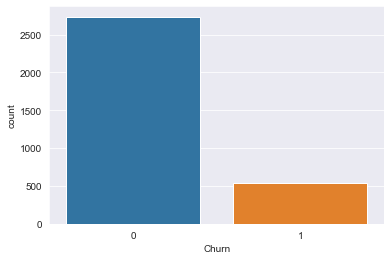

Ukuran dataset: (3270, 11)


0    2736
1     534
Name: Churn, dtype: int64

0    83.669725
1    16.330275
Name: Churn, dtype: float64

In [166]:
sns.countplot(df_new_3['Churn'])
plt.show()

print(f'Ukuran dataset: {df_new_3.shape}')

display(df_new_3['Churn'].value_counts())

display((df_new_3['Churn'].value_counts()/df_new_3.shape[0])*100)

Jika ditinjau dari proporsi target / Churn, data terindikasi imbalanced yang menyebabkan model akan cenderung untuk memprediksi kelas negatif. 

Oleh karena itu harus dilakukan imbalanced handling. Karena total data sedikit yaitu sekitar 3000 data, metode undersampling tidak direkomendasikan. Tapi pada sesi kali ini kita akan mencoba semua kemungkinan, maka akan dicoba metode balancing dengan undersampling dan oversampling.

In [167]:
def split_before_sampling():
    # split before sampling
    x_sampling, x_test_sampling, y_sampling, y_test_sampling = train_test_split(x_no_miss,
                                                                           y_no_miss, 
                                                                           stratify=y_no_miss,
                                                                           test_size=0.2,
                                                                           random_state=2022)
    
    return x_sampling, x_test_sampling, y_sampling, y_test_sampling

def training_with_sampling(method, x_sampling, x_test_sampling, y_sampling, y_test_sampling):
    # -- training
    score_training = []
    score_avg_training = []
    std_dev_training = []
    fpr_training = []
    
    # -- testing
    recall_testing = []
    fpr_testing = []
    roc_auc_testing = []
    class_report_testing = []
    confus_matrix_testing = []
    
    if method == 'oversampling':
        # oversampling
        sampling = SMOTENC(categorical_features=[3, 5], random_state=42)
    else:
        sampling = RandomUnderSampler(sampling_strategy='majority')
        
    x_train_sampling, y_train_sampling = sampling.fit_resample(x_sampling, y_sampling)
    
    # Plot
    sns.countplot(y_train_sampling)
    plt.title('Training Data')
    plt.show()

    print(f'Ukuran data training: {y_train_sampling.shape}')

    display(y_train_sampling.value_counts())
    display((y_train_sampling.value_counts()/y_train_sampling.shape[0])*100)
    
    sns.countplot(y_test_sampling)
    plt.title('Testing Data')
    plt.show()
    
    print(f'Ukuran data testing: {y_test_sampling.shape}')

    display(y_test_sampling.value_counts())
    display((y_test_sampling.value_counts()/y_test_sampling.shape[0])*100)
    
    # Training w/ balanced dataset
    for model in models:
        sk_fold = StratifiedKFold(n_splits=5)
        pipeline_model = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])

        model_cv=cross_val_score(pipeline_model, 
                                 x_train_sampling,
                                 y_train_sampling,
                                 cv=sk_fold,
                                 scoring='roc_auc')

        score_training.append([round(i, 2) for i in model_cv])
        score_avg_training.append(model_cv.mean())
        std_dev_training.append(model_cv.std())

    df_train = pd.DataFrame(data={'Algorithm': algoritma,
                                  'Average of ROC AUC': score_avg_training,
                                  'Standard Deviation of ROC AUC': std_dev_training,
                                  'Each of ROC AUC Score': score_training})

    # Testing
    for i, model in enumerate(models):
        pipeline_model = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])

        pipeline_model.fit(x_train_sampling, y_train_sampling)

        y_pred = pipeline_model.predict(x_test_sampling)
        y_pred_proba = pipeline_model.predict_proba(x_test_sampling)[:,1]
        confus_matrix_var = confusion_matrix(y_test_sampling, y_pred)

        recall_testing.append(recall_score(y_test_sampling, y_pred))
        fpr_testing.append(confus_matrix_var[0][1]/(confus_matrix_var[0][1]+confus_matrix_var[0][0]))
        roc_auc_testing.append(roc_auc_score(y_test_sampling, y_pred_proba))
        confus_matrix_testing.append(confus_matrix_var)
        class_report_testing.append(classification_report(y_test_sampling, y_pred))
        
    df_test = pd.DataFrame(data={'Algorithm': algoritma,
                                 'ROC AUC Score': roc_auc_testing,
                                 'Recall Score': recall_testing,
                                 'FPR': fpr_testing,})
    
    return df_train, df_test, class_report_testing, confus_matrix_testing

x_sample, x_test_sample, y_sample, y_test_sample = split_before_sampling()

## Oversampling With SMOTENC

Metode uji coba sampling yang pertama dilakukan dengan **SMOTENC**. Pertama akan dibagi terlebih dahulu data menjadi gugus training dan testing, setelah itu baru akan dilakukan oversampling/undersampling pada gugus data training. Hal ini agar mempertahankan dataset test agar tetap sama pada proporsi populasinya.

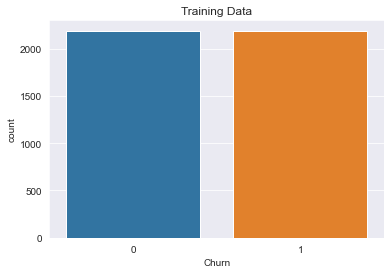

Ukuran data training: (4378,)


0    2189
1    2189
Name: Churn, dtype: int64

0    50.0
1    50.0
Name: Churn, dtype: float64

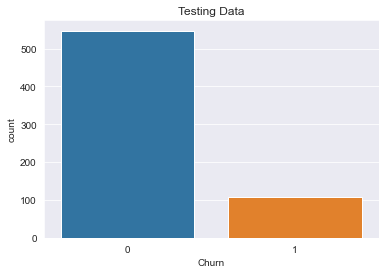

Ukuran data testing: (654,)


0    547
1    107
Name: Churn, dtype: int64

0    83.639144
1    16.360856
Name: Churn, dtype: float64

In [168]:
df_train_us, df_test_us, classif_report_us, confusion_matrix_us = training_with_sampling('oversampling', x_sample, x_test_sample, y_sample, y_test_sample)


In [169]:
display(df_train_us)
display(df_test_us)

for i, model in enumerate(models):
    print(f'Algorithm: {algoritma[i]}\n {classif_report_us[i]}')
    print(f'{confusion_matrix_us[i]}\n')

,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.869799,0.016149,"[0.84, 0.88, 0.86, 0.89, 0.88]"
1,KNN,0.939719,0.013158,"[0.92, 0.94, 0.94, 0.95, 0.95]"
2,Decision Tree,0.869124,0.038222,"[0.8, 0.9, 0.87, 0.87, 0.9]"
3,RF,0.972744,0.019499,"[0.93, 0.98, 0.98, 0.99, 0.98]"
4,XGBoost,0.982604,0.018147,"[0.95, 0.99, 0.99, 0.99, 0.99]"
5,LightGBM,0.978395,0.019954,"[0.94, 0.99, 0.99, 0.99, 0.99]"
6,Catboost,0.977079,0.020011,"[0.94, 0.99, 0.98, 0.99, 0.99]"
7,Adaboost,0.924370,0.027679,"[0.87, 0.93, 0.93, 0.95, 0.94]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.843001,0.803738,0.254113
1,KNN,0.826753,0.766355,0.241316
2,Decision Tree,0.805985,0.728972,0.117002
3,RF,0.920937,0.785047,0.078611
4,XGBoost,0.931197,0.747664,0.063985
5,LightGBM,0.928702,0.738318,0.063985
6,Catboost,0.932222,0.747664,0.069470
7,Adaboost,0.860035,0.710280,0.201097


Algorithm: Logistic Regression
               precision    recall  f1-score   support

           0       0.95      0.75      0.84       547
           1       0.38      0.80      0.52       107

    accuracy                           0.76       654
   macro avg       0.67      0.77      0.68       654
weighted avg       0.86      0.76      0.78       654

[[408 139]
 [ 21  86]]

Algorithm: KNN
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       547
           1       0.38      0.77      0.51       107

    accuracy                           0.76       654
   macro avg       0.66      0.76      0.68       654
weighted avg       0.85      0.76      0.79       654

[[415 132]
 [ 25  82]]

Algorithm: Decision Tree
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       547
           1       0.55      0.73      0.63       107

    accuracy                           0.86       654
   mac

Dari hasil training dengan cross validation dan testing, hasil recall naik jika dibandingkan dengan benchmark testing. Tapi model terindikasi overfitting karena score recall pada gugus testing memiliki hasil yang relatif lebih rendah jika dibandingkan dengan gugus training. Hal ini dapat terindikasi karena hasil dari oversampling yang kurang representatif. 

## Undersampling With RandomUnderSampling

Setelah mencoba metode oversampling, kita akan mencoba untuk melakukan undersampling dengan metode RandomUnderSampling, kemudian akan membandingkan kedua hasilnya.

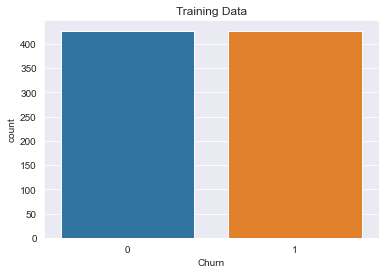

Ukuran data training: (854,)


0    427
1    427
Name: Churn, dtype: int64

0    50.0
1    50.0
Name: Churn, dtype: float64

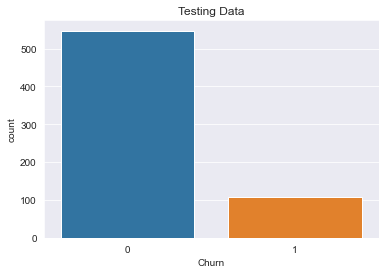

Ukuran data testing: (654,)


0    547
1    107
Name: Churn, dtype: int64

0    83.639144
1    16.360856
Name: Churn, dtype: float64

In [170]:
df_train_rus, df_test_rus, classif_report_rus, confusion_matrix_rus = training_with_sampling('undersampling', x_sample, x_test_sample, y_sample, y_test_sample)


In [171]:
display(df_train_rus)
display(df_test_rus)

for i, model in enumerate(models):
    print(f'Algorithm: {algoritma[i]}\n {classif_report_rus[i]}')
    print(f'{confusion_matrix_rus[i]}\n')

,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each of ROC AUC Score
0,Logistic Regression,0.886796,0.031687,"[0.89, 0.92, 0.89, 0.91, 0.83]"
1,KNN,0.805443,0.050409,"[0.81, 0.87, 0.81, 0.82, 0.72]"
2,Decision Tree,0.798591,0.030074,"[0.8, 0.84, 0.77, 0.77, 0.83]"
3,RF,0.923583,0.013644,"[0.93, 0.95, 0.91, 0.92, 0.92]"
4,XGBoost,0.923537,0.015629,"[0.93, 0.95, 0.91, 0.92, 0.91]"
5,LightGBM,0.927720,0.019011,"[0.94, 0.96, 0.91, 0.92, 0.92]"
6,Catboost,0.931251,0.015501,"[0.94, 0.95, 0.92, 0.93, 0.91]"
7,Adaboost,0.906989,0.016442,"[0.92, 0.93, 0.89, 0.9, 0.89]"


,Algorithm,ROC AUC Score,Recall Score,FPR
0,Logistic Regression,0.865075,0.841121,0.254113
1,KNN,0.786055,0.757009,0.274223
2,Decision Tree,0.784363,0.841121,0.272395
3,RF,0.916554,0.887850,0.177331
4,XGBoost,0.912983,0.859813,0.180987
5,LightGBM,0.915700,0.897196,0.179159
6,Catboost,0.922210,0.878505,0.170018
7,Adaboost,0.870551,0.831776,0.230347


Algorithm: Logistic Regression
               precision    recall  f1-score   support

           0       0.96      0.75      0.84       547
           1       0.39      0.84      0.54       107

    accuracy                           0.76       654
   macro avg       0.68      0.79      0.69       654
weighted avg       0.87      0.76      0.79       654

[[408 139]
 [ 17  90]]

Algorithm: KNN
               precision    recall  f1-score   support

           0       0.94      0.73      0.82       547
           1       0.35      0.76      0.48       107

    accuracy                           0.73       654
   macro avg       0.64      0.74      0.65       654
weighted avg       0.84      0.73      0.76       654

[[397 150]
 [ 26  81]]

Algorithm: Decision Tree
               precision    recall  f1-score   support

           0       0.96      0.73      0.83       547
           1       0.38      0.84      0.52       107

    accuracy                           0.75       654
   mac

Dari data tersebut, dapat dikatakan bahwa model dengan undersampling memiliki performansi yang lebih baik jika dibandingkan dengan model dengan oversampling.Performansi yang diperoleh yaitu recall setinggi-tingginya dan FPR yang serendah2nya dengan standar deviasi recall pada gugus data training memiliki nilai yang relatif kecil. Model juga tidak terindikasi overfitting dan underfitting karena score yang diperoleh pada training dan testing relatif balance dan cukup baik. 

Model yang paling baik dengan recall tinggi dan FPR paling rendah (ROC AUC yang paling tinggi) pada gugus data testing adalah catboost. Model ini juga memiliki recall yang baik dan standar deviasi dari recall yang kecil, yang artinya model cukup stabil jika diuji pada gugus data yang berbeda. Untuk selanjutnya kita akan menggunakan model ini untuk hyperparameter tunning.

## Hyperparameter Tuning

Untuk meningkatkan performansi model (ROC AUC, Recall, FPR), kita akan melakukan hyperparameter tuning untuk model Cat Boost dengan 3 hyperparameter yaitu sebagai berikut.
- n_estimators
- max_depth
- learning_rate

In [172]:
model = CatBoostClassifier(silent=True)
hyperparam_space_catboost=[{
    'model__n_estimators' : [100, 200, 300, 400, 500],
    'model__max_depth': [i for i in range(1, 11)],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
}]

# hyperparam_space_catboost=[{
#     'model__n_estimators' : [100],
#     'model__max_depth': [3, 4],
#     'model__learning_rate': [0.001],
# }]

#     'model__n_estimators' : [100, 200, 300],
#     'model__max_depth': [i for i in range(1, 11)],
#     'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
#     'model__iterations': [i for i in range(10, 101, 10)]

rus = RandomUnderSampler(sampling_strategy='majority', random_state=2022)
x_train_fin, y_train_fin = rus.fit_resample(x_train, y_train)

estimator = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

grid = GridSearchCV(estimator, 
#                     n_jobs=-1, 
                    param_grid=hyperparam_space_catboost, 
                    scoring='roc_auc', 
                    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

grid.fit(x_train_fin, y_train_fin)
print(f'Best score: {grid.best_score_}')
print(f'Best params: {grid.best_params_}')

Best score: 0.9241700790646167
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 400}


Score ROC AUC yang diperoleh yaitu 92.4%. Setelah itu kita akan membandingkan model sebelum dituning dan setelah dituning yang prosesnya adalah sebagai berikut.

In [173]:
# default model
default_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])
default_model.fit(x_train_fin, y_train_fin)

# best model
final_model = grid.best_estimator_
final_model.fit(x_train_fin, y_train_fin)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('miss',
                                                  KNNImputer(n_neighbors=3),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'DaySinceLastOrder']),
                                                 ('enc',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001E731DB9D60>)])

In [190]:
roc_auc_final = []
avg_roc_auc_final = []
std_dev_final = []

model_cv = cross_val_score(final_model, x_train_fin, y_train_fin, cv=sk_fold, scoring='roc_auc')
    
roc_auc_final.append([round(i, 2) for i in model_cv])
avg_roc_auc_final.append(model_cv.mean())
std_dev_final.append(model_cv.std())

pd.DataFrame(data={'Algorithm': 'Final Model With CatBoost',
                   'Average of ROC AUC': avg_roc_auc_final,
                   'Standard Deviation of ROC AUC': std_dev_final,
                   'Each ROC AUC Score': roc_auc_final,})

,Algorithm,Average of ROC AUC,Standard Deviation of ROC AUC,Each ROC AUC Score
0,Final Model With CatBoost,0.92148,0.011274,"[0.91, 0.91, 0.93, 0.94, 0.92]"


In [174]:
# Testing
y_pred_default = default_model.predict(x_test)
y_pred_proba_default = default_model.predict_proba(x_test)

y_pred_tuned = final_model.predict(x_test)
y_pred_proba_tuned = final_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

recall_default = recall_score(y_test, y_pred_default)
recall_tuned = recall_score(y_test, y_pred_tuned)

con_mat_default = confusion_matrix(y_test, y_pred_default)
con_mat_tuned = confusion_matrix(y_test, y_pred_tuned)

fpr_default = con_mat_default[0][1]/(con_mat_default[0][1]+con_mat_default[0][0])
fpr_tuned = con_mat_tuned[0][1]/(con_mat_tuned[0][1]+con_mat_tuned[0][0])

display(pd.DataFrame(data={'Recall': [recall_default, recall_tuned],
                           'FPR': [fpr_default, fpr_tuned],
                           'ROC AUC': [roc_auc_default, roc_auc_tuned]},
                     index=['Default Model', 'Tuned Model']))

print('ROC AUC Score Default: \n', con_mat_default)
print('\nROC AUC Score Tuned: \n', con_mat_tuned)

,Recall,FPR,ROC AUC
Default Model,0.841121,0.151737,0.930786
Tuned Model,0.878505,0.138940,0.930018


ROC AUC Score Default: 
 [[464  83]
 [ 17  90]]

ROC AUC Score Tuned: 
 [[471  76]
 [ 13  94]]


In [175]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default Model: \n', report_default)
print('Classification Report Tuned Model: \n', report_tuned)

Classification Report Default Model: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90       547
           1       0.52      0.84      0.64       107

    accuracy                           0.85       654
   macro avg       0.74      0.84      0.77       654
weighted avg       0.89      0.85      0.86       654

Classification Report Tuned Model: 
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       547
           1       0.55      0.88      0.68       107

    accuracy                           0.86       654
   macro avg       0.76      0.87      0.80       654
weighted avg       0.90      0.86      0.88       654



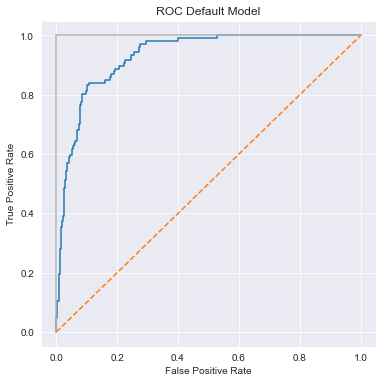

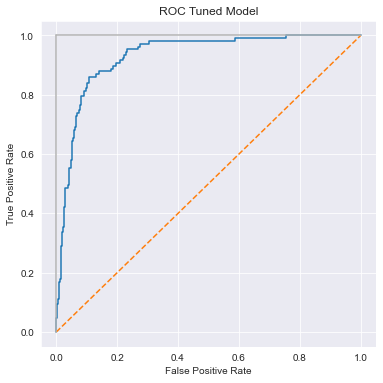

In [176]:
def plot_auc(y_test, y_pred_proba, titles):
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[::,1])
    
    plt.subplots(1, figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.title(titles)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, y_pred_proba_default, 'ROC Default Model')
plot_auc(y_test, y_pred_proba_tuned, 'ROC Tuned Model')

Score ROC AUC setelah dilakukan hyperparameter tuning cenderung stabil. Tapi score recall yang diperoleh lebih tinggi, begitu juga score FPR yang didapatkan lebih kecil. Yang artinya performansi yang diperoleh meningkat.

# Feature Importances

Sekarang kita akan menentukan fitur yang paling penting untuk model yang dibangun.

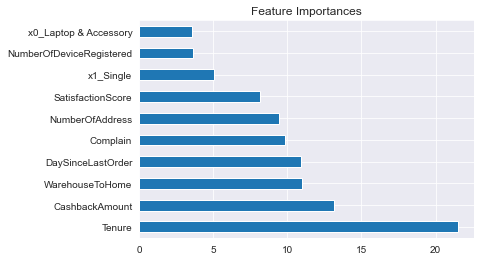

In [177]:
feature_final = missing_feature + pipeline_model['preprocess'].transformers_[1][1].get_feature_names().tolist() + ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount']

feat_imp = pd.Series(final_model['model'].feature_importances_, feature_final).sort_values(ascending = False).head(10)
feat_imp.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat seperti dugaan awal, bahwa fitur **Tenure** akan diprediksi menjadi prediktor yang baik untuk kasus ini diikuti oleh fitur **CashbackAmount** dan seterusnya.

# Conclusion & Recommendation

In [183]:
print('Classification Report CatBoost Model Tuned: \n', report_tuned)

Classification Report CatBoost Model Tuned: 
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       547
           1       0.55      0.88      0.68       107

    accuracy                           0.86       654
   macro avg       0.76      0.87      0.80       654
weighted avg       0.90      0.86      0.88       654



### Conclusion

Berdasarkan hasil classification report dari model. Jika kita mengimplementasikan model ini, kurang lebih kita akan benar memprediksi sekitar 86% (recall) pelanggan yang benar-benar akan churn dengan benar. Tapi kita kurang tepat memprediksi sekitar 55% (precision) orang yang akan churn padahal pelanggan terkait tidak akan churn.

Dengan mengasumsikan terdapat 100 orang yang benar akan churn, dan dengan asumsi setelah kita memberikan 1 penawaran khusus (diskon/cashback dengan berbagai metode yang berkaitan dengan tim bisnis) pelanggan terkait tidak akan churn. Maka kita dapat mempertahankan 86 pelanggan untuk tidak churn. Akan tetapi dengan precision yang masih kurang tinggi (karena data imbalanced), maka kita akan kelebihan mengeluarkan 45% penawaran khusus yang mungkin sia-sia. Hal ini dapat menjadi pertimbangan lebih lanjut untuk melakukan improvement selanjutnya.

### Recommendation / Improvement

Rekomendasi untuk pengembangan lebih lanjut agar lebih baik lagi adalah sebagai berikut.
- Menggunakan model lain yang belum dicoba.
- Menambah jumlah feature dengan berbagai teknik feature engineering untuk meningkatkan performansi model.
- Mencoba menangani outlier tanpa menghapus/mendrop data.
- Mempertimbangkan metriks lain untuk dijadikan patokan seperti presisi, f1-score, dll.

# Export Model

In [182]:
file_name = 'model.sav'
pickle.dump(final_model, open(file_name, 'wb'))

# Thank You & Wish Me Luck!